Problem Statement:
Abandoned buildings and property is a common plight that urban centers face  

According to the existing literature, abandoned buildings and land in a city are responsible for:

    increasing crime rates (drug use, prostitution, etc.) 
    increasing danger for public health and safety (collapsing parts of buildings, fires, etc.)
    depressing nearby property values 
    generating low property taxes; increasing costs for local governments (to secure, inspect, provide additional police and fire services, etc.) 
    
In other words, abandoned buildings and land in the city contribute to the downgrade of the quality of life, 
creating an unattractive urban environment for the citizens and visitors, as well as for future investors


Business Potential:
                    
    Real Estate Agencies can identify and proceed to buy these buildings
    Municipalities may want to transform them for other purposes.
    Investors can get the upper hand when searching for vacant buildings to buy.
    Businesses can easily assess the surrounding area for possible dangers when census data are scarse or outdated.
                    
Anyone can locate an abandonded building just by having a walk around but naturally this is inefficient.


In [1]:
# google Housing Vacancy

https://www.tandfonline.com/doi/abs/10.1080/01431161.2019.1615655?journalCode=tres20
    
https://www.mdpi.com/2072-4292/10/12/1920    

https://www.researchgate.net/publication/350617115_Detecting_individual_abandoned_houses_from_google_street_view_A_hierarchical_deep_learning_approach

https://www.arcgis.com/home/item.html?id=d3da5dd386d140cf93fc9ecbf8da5e31

https://www.arcgis.com/home/item.html?id=d3da5dd386d140cf93fc9ecbf8da5e31

https://www.nerdwallet.com/article/small-business/business-location
    
https://journalistsresource.org/politics-and-government/abandoned-buildings-revitalization/
    
https://www.fortunebuilders.com/vacant-property/

### Can freely available AND easily accessible satellite data detect abandonded buildings?

We are going to approach this topic from different angles

1) Use Google Earth Engine since it offers a great variety of data, has a relatively good python api, and because anyone can access it

2) Use Sentinel Hub since it has a great python API and there are existing libraries for a lot of tasks. However it's not free

Methodology

Data Collection:
    
    Get satellite data from Sentinel-2 (10m spatial resolution) and Landsat-8(30m spatial resolution)
    
    Get satellite data from VIIRS(750m spatial resolution-yep bad) since absence of light may indicate abandonment
    
    Possibly get google satellite images(bigger spatial resolution but outdated), can be used to identify characteristics of an abandonded building
    
    OSM geojson for buildings
    
Preprocessing: 
    
    Cloud Masks for all data
    
    Use neural network in order to improve spatial resolution of Sentinel-2 images (
    https://up42.com/blog/tech/sentinel-2-superresolution
    https://github.com/lanha/DSen2
    https://github.com/up42/DSen2)
    
    Possibly deblur VIIRs, or use them along with DMSP-OLS

Models:
    
    Map NDVI,NDWI since abandonded places tend to have low vegetation or water
    
    Measure Mean Radiance of Lights over a particular area


NPP-VIIRS PREPROCESSING from housing_vacancy-npp.pdf
The minimum value of NPP-VIIRS data
should be 0, representing regions without light intensity. However, values of a few pixels
were lower than 0, caused by imaging error. In our study, these negative values were
reset to 0. (2) Some abruptly large pixel also existed which might be extraordinary noises
or pixels associated with the weak light reflected by high reflectance surfaces (e.g. snowcapped mountains). To distinguish these pixels, the maximum radiance value derived
from the city centre artificially was first set as the upper threshold and then used to
distinguish pixels with larger values. A Max Filter was used in these abnormal pixels to
fix their values. In this way, the background noises of NPP-VIIRS NTL data was eliminated
effectively.

https://www.esri.com/about/newsroom/arcnews/start-up-fights-urban-blight/

https://github.com/d-smit/sentinel2-deep-learning

https://github.com/sentinel-hub/multi-temporal-super-resolution


https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/

https://www.tandfonline.com/doi/abs/10.1080/01431161.2017.1331060

https://github.com/KlemenKozelj/sentinel2-earth-observation

https://code.earthengine.google.com/?scriptPath=Examples%3ADatasets%2FCOPERNICUS_S2_SR

https://code.earthengine.google.com/?scriptPath=Examples%3ADatasets%2FSKYSAT_GEN-A_PUBLIC_ORTHO_MULTISPECTRAL

In [2]:
#Firstly, we will do the analysis, with almost zero preprocessing

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime

from pprint import pprint
from rasterio.features import Window
from rasterio.windows import bounds
from shapely.geometry import MultiPolygon, box
from PIL import Image
from rasterio.features import Window
from subprocess import call
from IPython import display

In [2]:
# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal

try:
    import geemap, ee
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
    import geemap, ee

Get Sentinel-2 Data though Google Earth Engine

We focus on Thessaly

In [4]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# get our Nepal boundary
aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME','Thessalia')).geometry()

# Sentinel-2 image filtered on 2019 and on Nepal
se2 = ee.ImageCollection('COPERNICUS/S2').filterDate("2015-01-01","2022-05-01").filterBounds(aoi).median().divide(10000)

rgb = ['B4','B3','B2']

# set some thresholds
rgbViz = {"min":0.0, "max":0.3,"bands":rgb}


# initialize our map
map1 = geemap.Map()
map1.centerObject(aoi, 7)
map1.addLayer(se2.clip(aoi), rgbViz, "S2")

map1.addLayerControl()
map1

Map(center=[39.51314304598321, 22.211757970370197], controls=(WidgetControl(options=['position', 'transparent_…

In [4]:
from ipyleaflet import GeoJSON
from geemap import geojson_to_ee, ee_to_geojson

Map = geemap.Map()
ee_data = geojson_to_ee('./data/planet_22.6586,39.256_23.2218,39.4689.geojson')
Map.addLayer(ee_data, {}, "Volos")

EEException: Request payload size exceeds the limit: 10485760 bytes.

The image is not clipped near coastal areas which may be problematic for our analysis as we go further.

Get VIIRS Data through Google Earth Engine

I select data between 2015 and 2022(latest available trhough the engine) since I want to capture the whole covid situation as well as changes possibly related to politics etc.

In [29]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2015-01-01','2022-05-01').select('avg_rad')

In [6]:
viirs

In [30]:
viirsJan2015= ee.Image(viirs)

# or equivalently

viirsJan2015 = viirs.first()


In [31]:
scaleFactor=100

greece_pref = ee.FeatureCollection(viirsJan2015.reduceRegions(reducer=ee.Reducer.mean(),
                                        collection=aoi,
                                        scale=scaleFactor))

In [32]:
radiance_img = greece_pref.reduceToImage(properties=['mean'],reducer=ee.Reducer.first());

In [33]:
#map1 = geemap.Map()
#map1.centerObject(aoi, zoom=7)
viz_params = {'min':1,
              'max':17,
              'palette':['2C105C','711F81','B63679','EE605E','FDAE78','FCFDBF']}
map1.addLayer(greece_pref, {}, "Prefecture boundaries", opacity=.5)
map1.addLayer(radiance_img, viz_params, 'VIIRS Jan 2015 avg rad by prefecture',opacity=.6)
map1.addLayerControl()
map1

Map(bottom=6641.0, center=[37.633282351146185, 22.153018572187033], controls=(WidgetControl(options=['position…

thessalia = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM1_NAME', 'Thessalia'))

print(f"There are {thessalia.size().getInfo()} level one admin units in Thessalia.")
thessalia.getInfo()

In [34]:
# file for Greece
magnisia = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM2_NAME', 'Magnisias'))).geometry()

A region that has lower-levels of light may be affected by background light that the VIIRS instrument is sensitive to can influence interpretation. 

As we look at this scene, you can see the relatively high levels of “noise” present.

As discussed earlier, one approach to increase the signal / noise ratio would be to reduce data over time.

But if the noise levels persist throughout the time period, that may not reduce the noise much. And what if your analysis is specifically to look at December 2017?

Or what if you’re looking to conduct comparative analysis on these data or use them as inputs for a model for statistical inference?

In this case, you will very likely want to reduce the noise levels in your data in order for your algorithm to learn your data without over-fitting (in other words, a more sensitive model might “learn” the noise…which is generally bad). Additionally, many loss functions are subject to “exploding” or “vanishing” gradients if your data are not close to zero and scale

In [35]:
scaleFactor=500

greeceSOL500 = viirsJan2015.reduceRegion(reducer=ee.Reducer.sum(),
                                     geometry=aoi,
                                     scale=scaleFactor,
                                     maxPixels=2e9)
print(f"The SOL for Greece at {scaleFactor}m scale is: {greeceSOL500.get('avg_rad').getInfo():.2f}")

The SOL for Greece at 500m scale is: 68533.30


In [36]:
scaleFactor=100

greeceSOL100 = viirsJan2015.reduceRegion(reducer=ee.Reducer.sum(),
                                     geometry=aoi,
                                     scale=scaleFactor,
                                     maxPixels=2e9)

print(f"The SOL for Greece at {scaleFactor}m scale is: {greeceSOL100.get('avg_rad').getInfo():.2f}")

The SOL for Greece at 100m scale is: 1715980.21


In [14]:
# Sum of Lights is prone to erros and outliers, and we can see that depending on the scale factor the results vary greatly
# Thus we will try another metric, mean lights

In [37]:
scaleFactor=500

greeceSOL = viirsJan2015.reduceRegion(reducer=ee.Reducer.mean(),
                                     geometry=aoi,
                                     scale=scaleFactor,
                                     maxPixels=2e9)

print(f"The avg radiance for Greece in Jan 2019 (per {scaleFactor}m grid) is: {greeceSOL.get('avg_rad').getInfo():.4f}")

The avg radiance for Greece in Jan 2019 (per 500m grid) is: 0.9294


In [38]:
scaleFactor=100

greeceSOL = viirsJan2015.reduceRegion(reducer=ee.Reducer.mean(),
                                     geometry=aoi,
                                     scale=scaleFactor,
                                     maxPixels=2e9)

print(f"The avg radiance for Greece in Jan 2019 (per {scaleFactor}m grid) is: {greeceSOL.get('avg_rad').getInfo():.4f}")

The avg radiance for Greece in Jan 2019 (per 100m grid) is: 0.9308


In [39]:
greece_pref.aggregate_stats('mean').getInfo()

{'max': None,
 'mean': 0.9308063247648654,
 'min': None,
 'sample_sd': 0,
 'sample_var': 0,
 'sum': 0.9308063247648654,
 'sum_sq': 0.866400414222276,
 'total_count': 1,
 'total_sd': 0,
 'total_var': 0,
 'valid_count': 1,
 'weight_sum': 1,
 'weighted_sum': 0.9308063247648654}

In [19]:
#Let's check the activity at T.Oikonomaki and the neighbouring areas that comprise a part of Volos' city center.

In [17]:
poi_oikonomaki= ee.Geometry.Polygon([[[
              22.949098348617554,39.35979978548018],
            [22.951193153858185,39.35979978548018 ],
            [22.951193153858185,39.36196275350115],
            [22.949098348617554,39.36196275350115],
            [22.949098348617554,39.35979978548018]]])

In [5]:
poi_rozou =ee.Geometry.Polygon(  [
          [
            [
              22.944881916046143,
              39.36383326244071
            ],
            [
              22.947140336036682,
              39.36383326244071
            ],
            [
              22.947140336036682,
              39.36550879775804
            ],
            [
              22.944881916046143,
              39.36550879775804
            ],
            [
              22.944881916046143,
              39.36383326244071
            ]
          ]
        ])

In [22]:
#poi = ee.Geometry.Point(22.9416,39.3725).buffer(1600)

In [40]:
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi_oikonomaki, scale=30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)
#this function takes as input the image and our desired point of interest as geometry

In [41]:
def poi(poi):
    selected_poi =  poi
    return  selected_poi
# function to use in case we want a lot of pois in a particular area, in order to automate it

In [42]:

poi_reduced_imgs = viirs.map(poi_mean)

In [43]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [44]:
import pandas as pd
# dont forget we need to call the callback method "getInfo" to retrieve the data
magnisia_lights = pd.DataFrame(nested_list.getInfo(), columns=['date','mean_rad'])

magnisia_lights

date    mean_rad
0   2015-01-01T00:00:00   73.326321
1   2015-02-01T00:00:00   76.881200
2   2015-03-01T00:00:00   77.527916
3   2015-04-01T00:00:00   66.776198
4   2015-05-01T00:00:00   69.973274
5   2015-06-01T00:00:00   63.349769
6   2015-07-01T00:00:00   62.108738
7   2015-08-01T00:00:00   54.692135
8   2015-09-01T00:00:00   59.888587
9   2015-10-01T00:00:00   61.506217
10  2015-11-01T00:00:00   65.814455
11  2015-12-01T00:00:00  106.768718
12  2016-01-01T00:00:00   87.334507
13  2016-02-01T00:00:00   77.143845
14  2016-03-01T00:00:00   73.929847
15  2016-04-01T00:00:00   71.543443
16  2016-05-01T00:00:00   71.713877
17  2016-06-01T00:00:00   68.684352
18  2016-07-01T00:00:00   56.791473
19  2016-08-01T00:00:00   62.941523
20  2016-09-01T00:00:00   75.546850
21  2016-10-01T00:00:00   73.608817
22  2016-11-01T00:00:00   70.646515
23  2016-12-01T00:00:00   91.325696
24  2017-01-01T00:00:00   95.029408
25  2017-02-01T00:00:00   75.412098
26  2017-03-01T00:00:00   79.338095
27  2017-04-01T00:00:00   72.871595
28  2017-05-01T00:00:00   72.817765
29  2017-06-01T00:00:00   70.463217
30  2017-07-01T00:00:00   78.372455
31  2017-08-01T00:00:00   69.923583
32  2017-09-01T00:00:00   73.861844
33  2017-10-01T00:00:00   91.302020
34  2017-11-01T00:00:00   95.006082
35  2017-12-01T00:00:00  114.809423
36  2018-01-01T00:00:00   64.746519
37  2018-02-01T00:00:00   66.740474
38  2018-03-01T00:00:00   84.355495
39  2018-04-01T00:00:00   82.170088
40  2018-05-01T00:00:00   77.102416
41  2018-06-01T00:00:00   64.135897
42  2018-07-01T00:00:00   63.814674
43  2018-08-01T00:00:00   71.814954
44  2018-09-01T00:00:00   73.192618
45  2018-10-01T00:00:00   65.576723
46  2018-11-01T00:00:00   93.728898
47  2018-12-01T00:00:00  108.578872
48  2019-01-01T00:00:00   90.549354
49  2019-02-01T00:00:00  104.645225
50  2019-03-01T00:00:00   87.375170
51  2019-04-01T00:00:00   81.283790
52  2019-05-01T00:00:00   87.353310
53  2019-06-01T00:00:00   75.997279
54  2019-07-01T00:00:00   81.837912
55  2019-08-01T00:00:00   70.095960
56  2019-09-01T00:00:00   70.455684
57  2019-10-01T00:00:00   79.595229
58  2019-11-01T00:00:00   65.320076
59  2019-12-01T00:00:00  104.908926
60  2020-01-01T00:00:00   93.914680
61  2020-02-01T00:00:00   94.146776
62  2020-03-01T00:00:00   67.991323
63  2020-04-01T00:00:00   88.166219
64  2020-05-01T00:00:00   81.825334
65  2020-06-01T00:00:00   75.102458
66  2020-07-01T00:00:00   66.587795
67  2020-08-01T00:00:00   76.807245
68  2020-09-01T00:00:00   79.292552
69  2020-10-01T00:00:00   83.920580
70  2020-11-01T00:00:00   82.549637
71  2020-12-01T00:00:00   98.458684
72  2021-01-01T00:00:00   74.403837
73  2021-02-01T00:00:00   96.350185
74  2021-03-01T00:00:00   76.911096
75  2021-04-01T00:00:00   93.097140
76  2021-05-01T00:00:00   89.468356
77  2021-06-01T00:00:00   71.689724
78  2021-07-01T00:00:00   74.074465
79  2021-08-01T00:00:00   71.765421
80  2021-09-01T00:00:00   77.834521
81  2021-10-01T00:00:00   90.763515
82  2021-11-01T00:00:00   89.638695
83  2021-12-01T00:00:00  111.807136
84  2022-01-01T00:00:00  103.584501
85  2022-02-01T00:00:00   93.361774
86  2022-03-01T00:00:00   73.508751
87  2022-04-01T00:00:00  106.272212

In [45]:
volosMap = geemap.Map()
volosMap.centerObject(poi_oikonomaki, zoom=13)
volosMap.add_basemap("SATELLITE")
volosMap.addLayer(poi_oikonomaki, {}, "T.Oikonomaki")
volosMap

Map(center=[39.360881268692346, 22.95014575125213], controls=(WidgetControl(options=['position', 'transparent_…

In [46]:
pd. set_option('display.max_rows', None)

magnisia_lights.date

0     2015-01-01T00:00:00
1     2015-02-01T00:00:00
2     2015-03-01T00:00:00
3     2015-04-01T00:00:00
4     2015-05-01T00:00:00
5     2015-06-01T00:00:00
6     2015-07-01T00:00:00
7     2015-08-01T00:00:00
8     2015-09-01T00:00:00
9     2015-10-01T00:00:00
10    2015-11-01T00:00:00
11    2015-12-01T00:00:00
12    2016-01-01T00:00:00
13    2016-02-01T00:00:00
14    2016-03-01T00:00:00
15    2016-04-01T00:00:00
16    2016-05-01T00:00:00
17    2016-06-01T00:00:00
18    2016-07-01T00:00:00
19    2016-08-01T00:00:00
20    2016-09-01T00:00:00
21    2016-10-01T00:00:00
22    2016-11-01T00:00:00
23    2016-12-01T00:00:00
24    2017-01-01T00:00:00
25    2017-02-01T00:00:00
26    2017-03-01T00:00:00
27    2017-04-01T00:00:00
28    2017-05-01T00:00:00
29    2017-06-01T00:00:00
30    2017-07-01T00:00:00
31    2017-08-01T00:00:00
32    2017-09-01T00:00:00
33    2017-10-01T00:00:00
34    2017-11-01T00:00:00
35    2017-12-01T00:00:00
36    2018-01-01T00:00:00
37    2018-02-01T00:00:00
38    2018-0

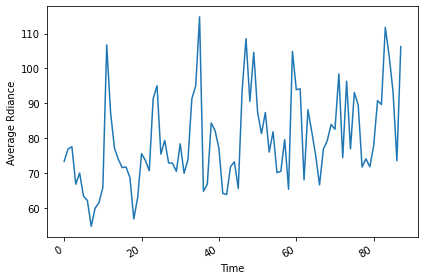

In [57]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots()
 
ax.plot(magnisia_lights['mean_rad'])
ax.set_xlabel('Time')
ax.set_ylabel('Average Rdiance')
 
# plt.xticks(
#     [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
#     ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
 
fig.autofmt_xdate()
plt.tight_layout()

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.[1]

In [59]:
from statsmodels.tsa.stattools import adfuller
 
ADF_result = adfuller(magnisia_lights['mean_rad'])
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.0374528426329224
p-value: 0.7393604004889622


In [63]:
import numpy as np
 
widget_sales_diff = np.diff(magnisia_lights['mean_rad'], n=1)

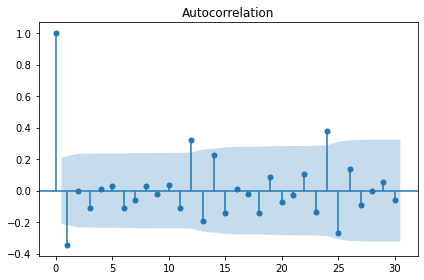

In [64]:
from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(widget_sales_diff, lags=30);
 
plt.tight_layout()

In [65]:

df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})
 
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]
 
print(len(train))
print(len(test))

78
9


In [66]:

ADF_result = adfuller(widget_sales_diff)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.68104671529535
p-value: 8.484916409650422e-07


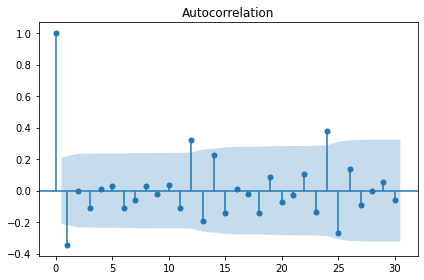

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(widget_sales_diff, lags=30);
 
plt.tight_layout()

In [68]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})
 
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]
 
print(len(train))
print(len(test))

78
9


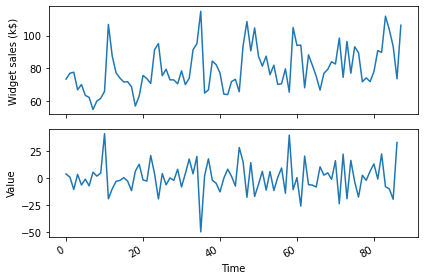

In [72]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
 
ax1.plot(magnisia_lights['mean_rad'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
# ax1.axvspan(450, 500, color='#808080', alpha=0.2)
 
ax2.plot(df_diff.widget_sales_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
# ax2.axvspan(450, 499, color='#808080', alpha=0.2)
 
# plt.xticks(
#     [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
#     ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
 
fig.autofmt_xdate()
plt.tight_layout()

In [54]:
# Sklearn
from sklearn.linear_model import LinearRegression

cols = magnisia_lights['mean_rad']
x= magnisia_lights.index.values.reshape(-1,1)
y = magnisia_lights['mean_rad']

# instantiate and fit
lm_2 = LinearRegression()
lm_2.fit(x, y)

# print the coefficients
print('Intercept: ', lm_2.intercept_)
print('mean: ', lm_2.coef_[0])

Intercept:  70.27433898688204
mean:  0.2151411141568455


C:\Users\Christos\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Christos\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmod

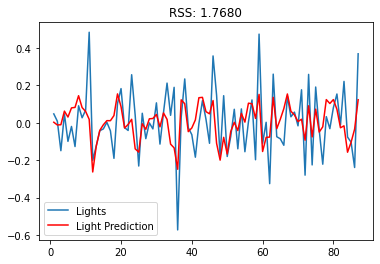

In [55]:
#from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
def arima_model(series):
    log_series = series.apply(lambda x: np.log(x))
    log_series_diff=log_series-log_series.shift()

    model=ARIMA(log_series, order=(1,1,1))
    results_ARIMA = model.fit(disp=-1)
    
    RSS = np.nansum((results_ARIMA.fittedvalues-log_series_diff)**2)
    return RSS, log_series_diff, results_ARIMA


RSS, log_series_diff, arima = arima_model(magnisia_lights['mean_rad'])
plt.plot(log_series_diff)
plt.plot(arima.fittedvalues, color='red')
plt.title('RSS: %.4f'% RSS)
plt.legend(['Lights', 'Light Prediction'])

In [48]:
#magnisia_lights['date'] = pd.to_datetime(magnisia_lights['date'])
from datetime import datetime,date
magnisia_lights['date'] = pd.to_datetime(magnisia_lights['date']).dt.date
df_ntl = magnisia_lights.set_index('date')

df_ntl

mean_rad
date                  
2015-01-01   73.326321
2015-02-01   76.881200
2015-03-01   77.527916
2015-04-01   66.776198
2015-05-01   69.973274
2015-06-01   63.349769
2015-07-01   62.108738
2015-08-01   54.692135
2015-09-01   59.888587
2015-10-01   61.506217
2015-11-01   65.814455
2015-12-01  106.768718
2016-01-01   87.334507
2016-02-01   77.143845
2016-03-01   73.929847
2016-04-01   71.543443
2016-05-01   71.713877
2016-06-01   68.684352
2016-07-01   56.791473
2016-08-01   62.941523
2016-09-01   75.546850
2016-10-01   73.608817
2016-11-01   70.646515
2016-12-01   91.325696
2017-01-01   95.029408
2017-02-01   75.412098
2017-03-01   79.338095
2017-04-01   72.871595
2017-05-01   72.817765
2017-06-01   70.463217
2017-07-01   78.372455
2017-08-01   69.923583
2017-09-01   73.861844
2017-10-01   91.302020
2017-11-01   95.006082
2017-12-01  114.809423
2018-01-01   64.746519
2018-02-01   66.740474
2018-03-01   84.355495
2018-04-01   82.170088
2018-05-01   77.102416
2018-06-01   64.135897
2018-07-01   63.814674
2018-08-01   71.814954
2018-09-01   73.192618
2018-10-01   65.576723
2018-11-01   93.728898
2018-12-01  108.578872
2019-01-01   90.549354
2019-02-01  104.645225
2019-03-01   87.375170
2019-04-01   81.283790
2019-05-01   87.353310
2019-06-01   75.997279
2019-07-01   81.837912
2019-08-01   70.095960
2019-09-01   70.455684
2019-10-01   79.595229
2019-11-01   65.320076
2019-12-01  104.908926
2020-01-01   93.914680
2020-02-01   94.146776
2020-03-01   67.991323
2020-04-01   88.166219
2020-05-01   81.825334
2020-06-01   75.102458
2020-07-01   66.587795
2020-08-01   76.807245
2020-09-01   79.292552
2020-10-01   83.920580
2020-11-01   82.549637
2020-12-01   98.458684
2021-01-01   74.403837
2021-02-01   96.350185
2021-03-01   76.911096
2021-04-01   93.097140
2021-05-01   89.468356
2021-06-01   71.689724
2021-07-01   74.074465
2021-08-01   71.765421
2021-09-01   77.834521
2021-10-01   90.763515
2021-11-01   89.638695
2021-12-01  111.807136
2022-01-01  103.584501
2022-02-01   93.361774
2022-03-01   73.508751
2022-04-01  106.272212

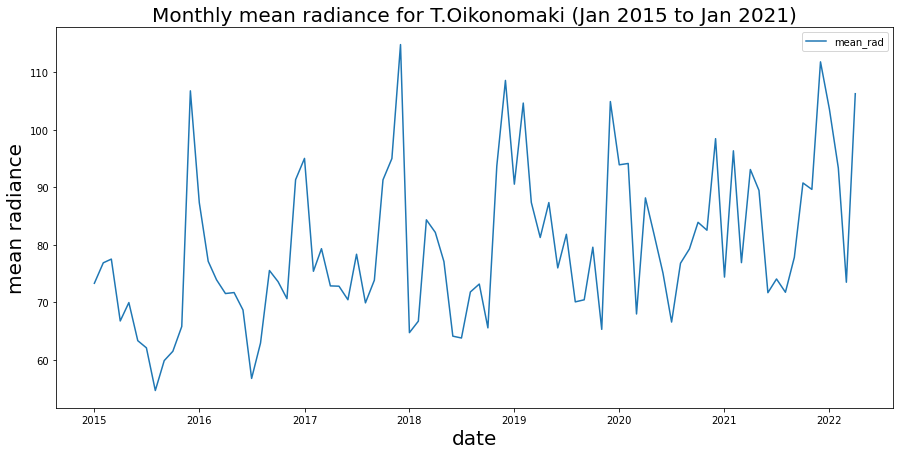

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(data=df_ntl, ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('Monthly mean radiance for T.Oikonomaki (Jan 2015 to Jan 2021)',fontsize=20);

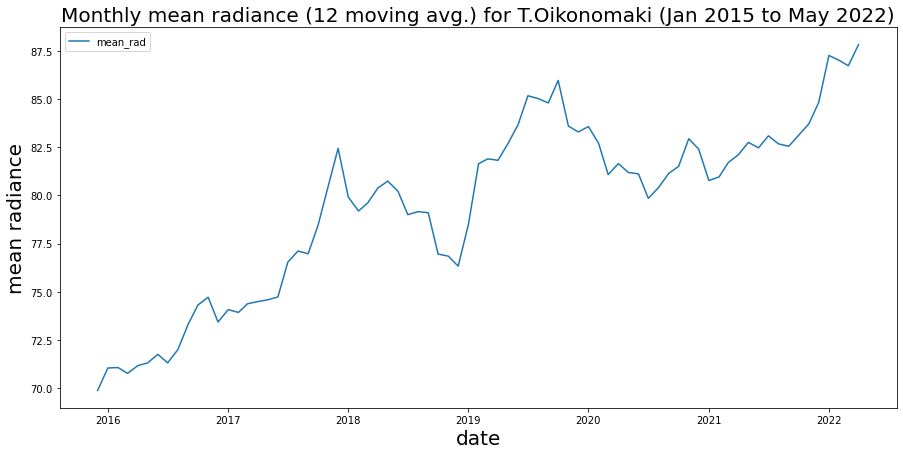

In [51]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=df_ntl.rolling(window).mean(), ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean radiance ({window} moving avg.) for T.Oikonomaki (Jan 2015 to May 2022)',fontsize=20);

In [35]:
df_ntl['mean_rad'].idxmax() 

datetime.date(2015, 12, 1)

In [36]:
#### otan to ooi einai h rozou mou kanei entypwsh

#### Otan poi einai h t.oik
This may be due to led lights in the city centre during the christmas period.
We are using mean which can be affected from outliers, i.e the leds are the outlier

Drop in 2019 could be due to COVID-19

In [37]:
#import data
from simple_ndvi.importData import importData

#manual Module
#folium
from simple_ndvi.myfolium import *


#indexes, topography and covariates
#from simple_ndvi.GetIndexes import GetIndexes
from simple_ndvi.GetIndexes import getNDVI

print("Initialized")

Initialized


### Visualization of ndvi over poi

In [38]:
# Create a folium map object.
#location = [22.9416,39.3725]
#mapObject = foliumInitialize(poi_rozou,6,600)
#my_map = mapObject.Initialize()
# initialize our map

map1.centerObject(poi_rozou, 7)
map1.addLayer(se2.clip(poi_rozou), rgbViz, "S2rozou")

map1.addLayerControl()

print('folium map Initialized')

folium map Initialized


In [39]:
startyear = 2015
endyear = 2022

startDate = ee.Date.fromYMD(startyear,1,1)
endDate = ee.Date.fromYMD(endyear,1,1)

#gee assets to get the study area
studyArea = poi_rozou



print("getting images")
ss2 = importData(studyArea,startDate,endDate)

ss2 = ss2.mean().clip(studyArea)

print(str(ss2.bandNames().getInfo()))

#get Indexes
print("getting indexes")
ss2 = getNDVI(ss2)
print(str(ss2.bandNames().getInfo()))

ss2 = ss2.select('ndvi')
print(str(ss2.bandNames().getInfo()))

ndviParams = {min: -1, max: 1, 'palette': ['blue', 'white', 'green']};
map1.add_ee_layer(ss2,ndviParams,'ndvi')
                    
print('done')
map1

getting images
['QA60', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'waterVapor', 'cirrus', 'swir1', 'swir2']
getting indexes
['QA60', 'blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'waterVapor', 'cirrus', 'swir1', 'swir2', 'ndvi']
['ndvi']
done


Map(center=[39.364671032161965, 22.946011126100565], controls=(WidgetControl(options=['position', 'transparent…

### Time Series Analysis of NDVI over our poi

In [40]:
print(str(ss2.bandNames().getInfo()))


['ndvi']


In [41]:
ss2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'ndvi',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'dimensions': [2, 2],
   'origin': [22, 38],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}],
 'properties': {'system:footprint': {'type': 'Polygon',
   'coordinates': [[[22.944881916046143, 39.36383326244071],
     [22.947140336036682, 39.36383326244071],
     [22.947140336036682, 39.36550879775804],
     [22.944881916046143, 39.36550879775804],
     [22.944881916046143, 39.36383326244071]]]}}}

In [42]:
#get sentile-2 as collection
se2_ndvi = ee.ImageCollection('COPERNICUS/S2_SR').filterDate("2015-01-01","2022-01-01").filterBounds(poi_rozou)
#collection = ee.ImageCollection('LANDSAT/LC08/C01/T1')
startyear = 2015
endyear = 2022

startDate = ee.Date.fromYMD(startyear,1,1)
endDate = ee.Date.fromYMD(endyear,1,1)
ss2 = importData(poi_rozou,startDate,endDate)
ss2

In [43]:
#fuction to add ndvi column on sentinel-2 collection
def addNDVI(image):
    ndvi = image.normalizedDifference(['nir', 'red']).rename('ndvi')
    return image.addBands(ndvi)
S2 = ss2.map(addNDVI);    
S2 = S2.select('ndvi')
#print(S2.getInfo())

In [44]:
def poi_mean(image):
    mean_ndvi = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi_rozou, scale=30).get('ndvi')
    return image.set('date', image.date().format()).set('mean_ndvi',mean_ndvi)
poi_ndvi = S2.map(poi_mean)

In [45]:
nested_list = poi_ndvi.reduceColumns(ee.Reducer.toList(2), ['date','mean_ndvi']).values().get(0)

In [46]:
mean_ndvi = pd.DataFrame(nested_list.getInfo(), columns=['date','mean_ndvi'])

mean_ndvi

date  mean_ndvi
0    2015-07-29T09:20:04   0.109704
1    2015-07-29T09:20:04   0.109752
2    2015-07-29T09:20:04   0.109752
3    2015-08-08T09:25:44   0.114728
4    2015-08-08T09:25:44   0.114728
5    2015-08-18T09:20:06   0.133126
6    2015-08-18T09:20:06   0.133032
7    2015-08-18T09:20:06   0.133126
8    2015-08-28T09:20:05   0.113603
9    2015-08-28T09:20:05   0.112808
10   2015-08-28T09:20:05   0.112808
11   2015-09-24T09:10:07   0.095927
12   2015-10-04T09:10:06   0.087444
13   2015-10-04T09:10:06   0.087444
14   2015-11-13T09:13:45   0.057501
15   2015-11-13T09:13:45   0.057501
16   2015-11-16T09:23:22   0.059989
17   2015-11-16T09:23:22   0.059989
18   2015-12-03T09:19:14   0.050157
19   2015-12-03T09:30:00   0.049005
20   2015-12-06T09:23:51   0.049790
21   2015-12-06T09:23:51   0.049790
22   2015-12-06T09:31:15   0.050334
23   2015-12-23T09:20:50   0.043009
24   2015-12-23T09:20:50   0.043009
25   2015-12-26T09:31:55   0.030401
26   2015-12-26T09:31:55   0.030401
27   2016-01-02T09:22:09   0.049567
28   2016-01-12T09:28:01   0.040196
29   2016-02-01T09:18:41   0.049310
30   2016-02-11T09:11:53   0.082508
31   2016-02-11T09:11:53   0.082508
32   2016-03-02T09:14:32   0.074094
33   2016-03-02T09:14:32   0.074094
34   2016-04-04T09:24:09   0.097981
35   2016-04-04T09:24:09   0.097981
36   2016-04-21T09:12:26   0.122512
37   2016-04-21T09:12:26   0.122512
38   2016-05-01T09:18:49   0.117865
39   2016-05-01T09:18:49   0.117865
40   2016-05-14T09:29:28   0.132365
41   2016-05-14T09:29:28   0.132365
42   2016-05-21T09:09:03   0.001346
43   2016-06-10T09:09:01   0.122990
44   2016-06-10T09:09:01   0.122990
45   2016-06-23T09:22:57   0.108040
46   2016-06-23T09:22:57   0.108040
47   2016-07-03T09:20:30   0.114619
48   2016-07-03T09:20:30   0.114619
49   2016-07-10T09:18:20   0.115723
50   2016-07-10T09:18:20   0.115723
51   2016-07-13T09:20:32   0.112505
52   2016-07-13T09:20:32   0.112505
53   2016-07-23T09:20:32   0.105348
54   2016-07-23T09:20:32   0.105348
55   2016-07-30T09:19:10   0.109105
56   2016-07-30T09:19:10   0.109105
57   2016-08-02T09:27:05   0.107173
58   2016-08-02T09:27:05   0.107173
59   2016-08-12T09:20:31   0.104807
60   2016-08-12T09:20:31   0.104807
61   2016-08-19T09:19:09   0.101299
62   2016-08-19T09:19:09   0.101299
63   2016-08-22T09:29:28   0.096189
64   2016-08-22T09:29:28   0.096189
65   2016-08-29T09:08:47   0.099073
66   2016-08-29T09:08:47   0.099073
67   2016-09-01T09:20:28   0.078999
68   2016-09-01T09:20:28   0.078999
69   2016-10-01T09:29:22   0.091740
70   2016-10-01T09:29:22   0.091740
71   2016-11-10T09:26:17   0.093828
72   2016-11-10T09:26:17   0.093828
73   2016-11-17T09:17:37   0.055561
74   2016-11-17T09:17:37   0.055561
75   2016-12-10T09:23:56   0.055120
76   2016-12-27T09:14:46   0.050126
77   2017-02-18T09:27:38   0.056796
78   2017-03-30T09:28:49   0.028850
79   2017-04-06T09:18:24   0.091577
80   2017-04-09T09:28:58   0.094144
81   2017-04-16T09:08:07   0.099302
82   2017-04-26T09:18:28   0.102025
83   2017-05-06T09:13:02   0.106826
84   2017-05-19T09:29:00   0.119172
85   2017-06-05T09:18:10   0.107457
86   2017-06-28T09:28:15   0.097831
87   2017-06-30T09:18:01   0.105556
88   2017-07-03T09:28:03   0.113345
89   2017-07-10T09:19:10   0.101535
90   2017-07-13T09:28:57   0.100427
91   2017-07-20T09:08:51   0.120478
92   2017-07-23T09:28:53   0.106132
93   2017-07-25T09:07:29   0.099125
94   2017-07-28T09:28:15   0.100666
95   2017-07-30T09:18:59   0.111416
96   2017-08-02T09:28:56   0.116733
97   2017-08-04T09:18:36   0.098957
98   2017-08-07T09:27:25   0.094641
99   2017-08-09T09:07:55   0.101679
100  2017-08-12T09:28:47   0.109010
101  2017-08-14T09:07:25   0.100127
102  2017-08-17T09:26:15   0.099815
103  2017-08-19T09:19:10   0.112060
104  2017-08-24T09:17:48   0.094810
105  2017-08-27T09:28:18   0.096805
106  2017-08-29T09:08:41   0.099664
107  2017-09-01T09:28:54   0.111071
108  2017-09-03T09:07:23   0.087510
109  2017-09-06T09:25:48   0.100303
110  2017-09-08T09:19:06

In [47]:
mean_ndvi['date'].nunique()

398

In [48]:
non_dup_date = mean_ndvi['date'].drop_duplicates()
non_dup_date.reset_index()

index                 date
0        0  2015-07-29T09:20:04
1        3  2015-08-08T09:25:44
2        5  2015-08-18T09:20:06
3        8  2015-08-28T09:20:05
4       11  2015-09-24T09:10:07
5       12  2015-10-04T09:10:06
6       14  2015-11-13T09:13:45
7       16  2015-11-16T09:23:22
8       18  2015-12-03T09:19:14
9       19  2015-12-03T09:30:00
10      20  2015-12-06T09:23:51
11      22  2015-12-06T09:31:15
12      23  2015-12-23T09:20:50
13      25  2015-12-26T09:31:55
14      27  2016-01-02T09:22:09
15      28  2016-01-12T09:28:01
16      29  2016-02-01T09:18:41
17      30  2016-02-11T09:11:53
18      32  2016-03-02T09:14:32
19      34  2016-04-04T09:24:09
20      36  2016-04-21T09:12:26
21      38  2016-05-01T09:18:49
22      40  2016-05-14T09:29:28
23      42  2016-05-21T09:09:03
24      43  2016-06-10T09:09:01
25      45  2016-06-23T09:22:57
26      47  2016-07-03T09:20:30
27      49  2016-07-10T09:18:20
28      51  2016-07-13T09:20:32
29      53  2016-07-23T09:20:32
30      55  2016-07-30T09:19:10
31      57  2016-08-02T09:27:05
32      59  2016-08-12T09:20:31
33      61  2016-08-19T09:19:09
34      63  2016-08-22T09:29:28
35      65  2016-08-29T09:08:47
36      67  2016-09-01T09:20:28
37      69  2016-10-01T09:29:22
38      71  2016-11-10T09:26:17
39      73  2016-11-17T09:17:37
40      75  2016-12-10T09:23:56
41      76  2016-12-27T09:14:46
42      77  2017-02-18T09:27:38
43      78  2017-03-30T09:28:49
44      79  2017-04-06T09:18:24
45      80  2017-04-09T09:28:58
46      81  2017-04-16T09:08:07
47      82  2017-04-26T09:18:28
48      83  2017-05-06T09:13:02
49      84  2017-05-19T09:29:00
50      85  2017-06-05T09:18:10
51      86  2017-06-28T09:28:15
52      87  2017-06-30T09:18:01
53      88  2017-07-03T09:28:03
54      89  2017-07-10T09:19:10
55      90  2017-07-13T09:28:57
56      91  2017-07-20T09:08:51
57      92  2017-07-23T09:28:53
58      93  2017-07-25T09:07:29
59      94  2017-07-28T09:28:15
60      95  2017-07-30T09:18:59
61      96  2017-08-02T09:28:56
62      97  2017-08-04T09:18:36
63      98  2017-08-07T09:27:25
64      99  2017-08-09T09:07:55
65     100  2017-08-12T09:28:47
66     101  2017-08-14T09:07:25
67     102  2017-08-17T09:26:15
68     103  2017-08-19T09:19:10
69     104  2017-08-24T09:17:48
70     105  2017-08-27T09:28:18
71     106  2017-08-29T09:08:41
72     107  2017-09-01T09:28:54
73     108  2017-09-03T09:07:23
74     109  2017-09-06T09:25:48
75     110  2017-09-08T09:19:06
76     111  2017-09-11T09:28:51
77     112  2017-09-13T09:18:32
78     113  2017-09-16T09:28:43
79     114  2017-09-18T09:08:11
80     115  2017-09-21T09:26:02
81     116  2017-09-23T09:08:29
82     117  2017-09-26T09:29:11
83     118  2017-10-06T09:20:26
84     119  2017-10-13T09:15:44
85     120  2017-10-16T09:27:40
86     121  2017-10-21T09:23:55
87     122  2017-11-02T09:17:46
88     123  2017-11-10T09:22:02
89     124  2017-11-22T09:14:53
90     125  2017-12-05T09:26:48
91     126  2017-12-07T09:13:48
92     127  2017-12-10T09:23:48
93     128  2017-12-12T09:17:48
94     129  2017-12-15T09:24:02
95     130  2017-12-25T09:28:07
96     131  2017-12-27T09:13:54
97     132  2017-12-30T09:24:50
98     133  2018-01-01T09:17:55
99     134  2018-01-06T09:13:42
100    135  2018-01-16T09:14:45
101    136  2018-01-19T09:24:46
102    137  2018-01-29T09:27:02
103    138  2018-01-31T09:15:13
104    139  2018-02-08T09:28:42
105    140  2018-02-28T09:25:36
106    141  2018-03-07T09:18:25
107    142  2018-03-10T09:21:38
108    143  2018-03-15T09:27:48
109    144  2018-03-20T09:24:16
110    145  2018-03-30T09:21:33
111    146  2018-04-04T09:20:28
112    147  2018-04-09T09:26:47
113    148  2018-04-14T09:20:29
114    149  2018-04-21T09:05:55
115    150  2018-04-24T09:20:30
116    151  2018-04-26T09:09:18
117    152  2018-04-29T09:24:07
118    153  2018-05-01T09:15:08
119    154  2018-05-04T09:25:16
120    155  2018-05-09T09:21:25
121    156  2018-05-14T09:20:31
122    157  2018-05-19T09:27:24
123    158  2018-05-21T09:05:56
124  

In [49]:
mean_ndvi['date'] = pd.to_datetime(mean_ndvi['date']).dt.date
ndvi_df = mean_ndvi.set_index('date')



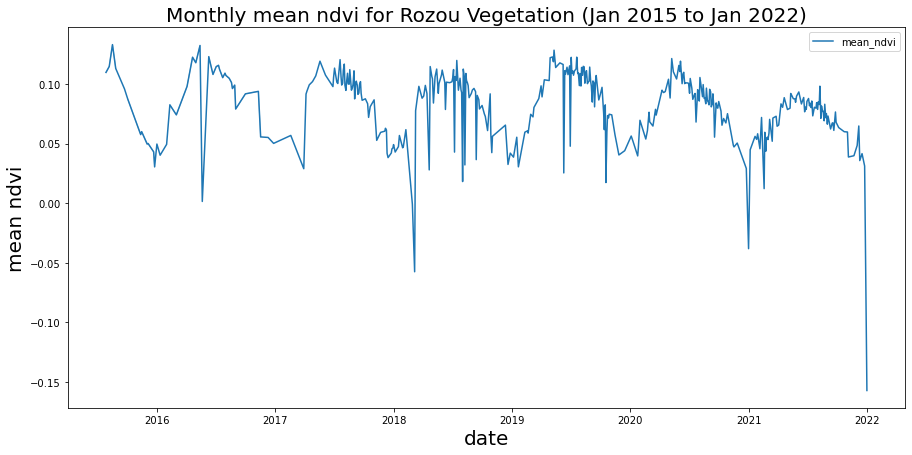

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(data=ndvi_df, ax=ax)


# we'll set the labels and title
ax.set_ylabel('mean ndvi',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('Monthly mean ndvi for Rozou Vegetation (Jan 2015 to Jan 2022)',fontsize=20);

These changes are probably due to seasons' changing.

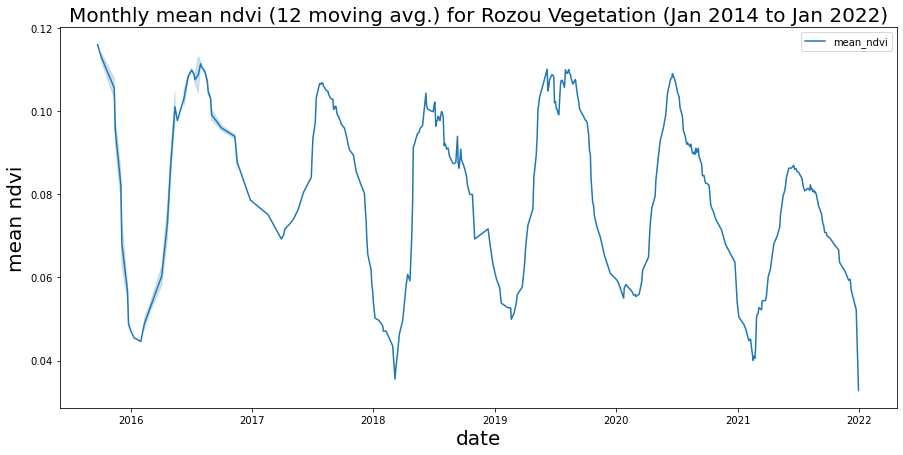

In [51]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=ndvi_df.rolling(window).mean(), ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean ndvi',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean ndvi ({window} moving avg.) for Rozou Vegetation (Jan 2014 to Jan 2022)',fontsize=20);

In [52]:
ndvi_df['mean_ndvi'].idxmax()

datetime.date(2015, 8, 18)

C:\Users\Christos\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Christos\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmod

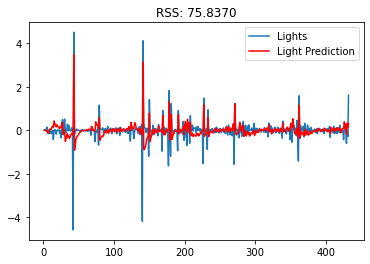

In [53]:
#from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
def arima_model(series):
    log_series = series.apply(lambda x: np.log(abs(x))) #to evala absolute giati to ndvi exei kai arnhtikes times
    log_series_diff=log_series-log_series.shift()

    model=ARIMA(log_series, order=(1,1,1))
    results_ARIMA = model.fit(disp=-1)
    
    RSS = np.nansum((results_ARIMA.fittedvalues-log_series_diff)**2)
    return RSS, log_series_diff, results_ARIMA


RSS, log_series_diff, arima = arima_model(mean_ndvi['mean_ndvi'])
plt.plot(log_series_diff)
plt.plot(arima.fittedvalues, color='red')
plt.title('RSS: %.4f'% RSS)
plt.legend(['Lights', 'Light Prediction'])

In [54]:
concat_df  = [df_ntl,ndvi_df]
concat_df = pd.concat(concat_df,ignore_index=False)
concat_df

mean_rad  mean_ndvi
date                             
2015-01-01   75.717593        NaN
2015-02-01   82.729182        NaN
2015-03-01   87.664364        NaN
2015-04-01   71.927072        NaN
2015-05-01   72.149910        NaN
2015-06-01   67.907429        NaN
2015-07-01   68.165832        NaN
2015-08-01   64.181778        NaN
2015-09-01   61.589812        NaN
2015-10-01   67.674662        NaN
2015-11-01   68.132474        NaN
2015-12-01  116.794261        NaN
2016-01-01   96.697813        NaN
2016-02-01   76.365986        NaN
2016-03-01   71.526220        NaN
2016-04-01   74.999388        NaN
2016-05-01   70.172157        NaN
2016-06-01   73.540262        NaN
2016-07-01   69.679542        NaN
2016-08-01   69.132942        NaN
2016-09-01   73.216173        NaN
2016-10-01   68.416330        NaN
2016-11-01   77.454858        NaN
2016-12-01   95.892599        NaN
2017-01-01   87.754563        NaN
2017-02-01   75.422087        NaN
2017-03-01   79.903508        NaN
2017-04-01   73.044732        NaN
2017-05-01   73.394904        NaN
2017-06-01   71.229001        NaN
2017-07-01   79.919542        NaN
2017-08-01   70.327869        NaN
2017-09-01   78.644540        NaN
2017-10-01   80.585122        NaN
2017-11-01   94.967504        NaN
2017-12-01   94.890808        NaN
2018-01-01   62.375916        NaN
2018-02-01   63.871662        NaN
2018-03-01   95.253972        NaN
2018-04-01   82.744520        NaN
2018-05-01   77.800769        NaN
2018-06-01   75.117417        NaN
2018-07-01   71.383886        NaN
2018-08-01   72.559605        NaN
2018-09-01   78.489598        NaN
2018-10-01   70.802667        NaN
2018-11-01   77.174406        NaN
2018-12-01  103.610318        NaN
2019-01-01   91.249213        NaN
2019-02-01  102.160881        NaN
2019-03-01   95.948000        NaN
2019-04-01   82.391516        NaN
2019-05-01   88.641132        NaN
2019-06-01   76.895293        NaN
2019-07-01   76.662809        NaN
2019-08-01   72.663818        NaN
2019-09-01   72.452966        NaN
2019-10-01   80.230264        NaN
2019-11-01   70.315462        NaN
2019-12-01  108.386855        NaN
2020-01-01   93.864018        NaN
2020-02-01   86.761515        NaN
2020-03-01   72.312979        NaN
2020-04-01   86.365598        NaN
2020-05-01   79.522015        NaN
2020-06-01   76.332711        NaN
2020-07-01   68.387594        NaN
2020-08-01   80.965472        NaN
2020-09-01   76.726657        NaN
2020-10-01   81.290556        NaN
2020-11-01   83.592807        NaN
2020-12-01   79.069859        NaN
2021-01-01   87.790413        NaN
2021-02-01   94.816653        NaN
2021-03-01   92.756299        NaN
2021-04-01   92.587730        NaN
2021-05-01   97.978836        NaN
2021-06-01   74.817061        NaN
2021-07-01   75.002478        NaN
2021-08-01   74.536792        NaN
2021-09-01   74.208344        NaN
2021-10-01   90.330721        NaN
2021-11-01   94.999424        NaN
2021-12-01  107.852817        NaN
2015-07-29         NaN   0.109704
2015-07-29         NaN   0.109752
2015-07-29         NaN   0.109752
2015-08-08         NaN   0.114728
2015-08-08         NaN   0.114728
2015-08-18         NaN   0.133126
2015-08-18         NaN   0.133032
2015-08-18         NaN   0.133126
2015-08-28         NaN   0.113603
2015-08-28         NaN   0.112808
2015-08-28         NaN   0.112808
2015-09-24         NaN   0.095927
2015-10-04         NaN   0.087444
2015-10-04         NaN   0.087444
2015-11-13         NaN   0.057501
2015-11-13         NaN   0.057501
2015-11-16         NaN   0.059989
2015-11-16         NaN   0.059989
2015-12-03         NaN   0.050157
2015-12-03         NaN   0.049005
2015-12-06         NaN   0.049790
2015-12-06         NaN   0.049790
2015-12-06         NaN   0.050334
2015-12-23         NaN   0.043009
2015-12-23         NaN   0.043009
2015-12-26         NaN   0.030401
2015-12-26         NaN   0.030401
2016-01-02         NaN   0.049567
2016-01-12         NaN   0.040196
2016-02-01         NaN   0.049310
2016-02-11         NaN   0.082508
2016-02-11         NaN   0.082508
20

In [55]:
a = concat_df['mean_rad'].fillna(concat_df['mean_rad'].mean())

b = concat_df['mean_ndvi'].fillna(concat_df['mean_ndvi'].mean())
c_df  = [a,b]
c_df = pd.concat(c_df,ignore_index=False)
c_df

date
2015-01-01     75.717593
2015-02-01     82.729182
2015-03-01     87.664364
2015-04-01     71.927072
2015-05-01     72.149910
2015-06-01     67.907429
2015-07-01     68.165832
2015-08-01     64.181778
2015-09-01     61.589812
2015-10-01     67.674662
2015-11-01     68.132474
2015-12-01    116.794261
2016-01-01     96.697813
2016-02-01     76.365986
2016-03-01     71.526220
2016-04-01     74.999388
2016-05-01     70.172157
2016-06-01     73.540262
2016-07-01     69.679542
2016-08-01     69.132942
2016-09-01     73.216173
2016-10-01     68.416330
2016-11-01     77.454858
2016-12-01     95.892599
2017-01-01     87.754563
2017-02-01     75.422087
2017-03-01     79.903508
2017-04-01     73.044732
2017-05-01     73.394904
2017-06-01     71.229001
2017-07-01     79.919542
2017-08-01     70.327869
2017-09-01     78.644540
2017-10-01     80.585122
2017-11-01     94.967504
2017-12-01     94.890808
2018-01-01     62.375916
2018-02-01     63.871662
2018-03-01     95.253972
2018-04-01     82.74

At this point we have obtained  the ndvi and avg radiance over our area of interest.
Ideally we want to create a model that can assess the amount of damage on a specified building\
Unfortunately there are some limitations mainly due to data avalability.

In [56]:
from sklearn.model_selection import train_test_split

NameError: name 'new_df' is not defined

In [60]:
import datetime as dt

new_df['date'] = magnisia_lights['date'] 
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['date']=new_df.map(dt.datetime.toordinal)
new_df['date']

NameError: name 'new_df' is not defined

In [58]:
y = magnisia_lights['mean_rad']
x = magnisia_lights['date']

X_train,X_test,Y_train,Y_test = train_test_split(x,y_2,test_size=0.3, random_state=42)

NameError: name 'y_2' is not defined

In [ ]:
yy= np.array(y).flatten()
xx=np.array(x)

In [ ]:
import datetime as dt

# .flatten converts numpy arrays into pandas df columns
df = pd.DataFrame(yy.flatten(),xx.flatten())  

# creates a new index (as pd.Dataframe made x_full_month the index initially)
df.reset_index(inplace=True) 
    
# meaningful column names
df = df.rename(columns = {'index':'ord_date',0:'cumul_DN'}) 
    
# Convert oridinal date to yyyy-mm-dd
df['date']=df['ord_date'].map(dt.datetime.toordinal) 

In [ ]:
x=np.arange(0,len(df['date']),1)
df['date']=x #
df

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
scaler = StandardScaler()
df['date'] = scaler.fit_transform(df['date'].values.reshape(-1,1))
df['cumul_DN'] = scaler.fit_transform(df['cumul_DN'].values.reshape(-1,1))

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(df['date'].values.reshape(-1,1), df['cumul_DN'],test_size=0.3, random_state=42)

# instantiate and fit
lm_2 = LinearRegression()
lm_2.fit(X_train, Y_train)

# print the coefficients
print('Intercept: ', lm_2.intercept_)
print('mean: ', lm_2.coef_[0])

In [ ]:
y_pred = lm_2.predict(X_test)

In [ ]:
lm_2.score(X_test,Y_test)

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
r2_score(Y_test,y_pred)

In [ ]:
mean_squared_error(Y_test, y_pred)

In [ ]:
# Plot outputs
plt.scatter(X_test, Y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
import numpy as np
import statsmodels.api as sm
import pylab

test = df['date']

sm.qqplot(test, line='45')
pylab.show()

In [ ]:
import numpy as np
import statsmodels.api as sm
import pylab

test = df['cumul_DN']

sm.qqplot(test, line='45')
pylab.show()

In [ ]:
a = concat_df['mean_rad'].fillna(concat_df['mean_rad'].mean())

b = concat_df['mean_ndvi'].fillna(concat_df['mean_ndvi'].mean())

In [ ]:
# summarize
from numpy import mean
from numpy import std
print('data1: mean=%.3f stdv=%.3f' % (mean(a), std(a)))
print('data2: mean=%.3f stdv=%.3f' % (mean(b), std(b)))
plt.scatter(a, b)
plt.show()

In [ ]:
df.date

In [ ]:
from numpy import cov
covariance = cov(a, b)
covariance

In [ ]:
from scipy.stats import pearsonr

corr, _ = pearsonr(a, b)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
map1

Find Abandoned Buildings

https://www.researchgate.net/publication/268816675_Assessment_of_Concrete_Surfaces_Using_Multi-Spectral_Image_Analysis

https://www.researchgate.net/publication/236941973_Intelligent_Concrete_Health_Monitoring_ICHM_An_Innovative_Method_for_Monitoring_Concrete_Structures_using_Multi_Spectral_Analysis_and_Image_Processing

In [ ]:
# mean radiance with fills
# we may want to only use monthly data in order to avoid filling with mean
# same goes for ndvi
a

In [ ]:
# mean ndvi with fills
b

Methodology

We hypothesise that when there is low avg radiance and higher mean ndvi there is a probability that a building is abandoned,
since vacant buildings shouldn't have any lights open and since they are unmaintained grass etc should be present.

We set up a threshold for these values
rad_thresh < mean_rad
ndvi_thresh > mean_ndvi

https://github.com/awesome-spectral-indices/awesome-spectral-indices

In [ ]:
for i in range(len(a)):
    if(a[i] < 80.403156 and b[i] > 0.083002):
        print(i)
        print(a[i])
        print(b[i])
        print("chance for abandoned building")

In [ ]:
if((a[-2] < 80.403156 and b[-2] > 0.083002)):
    print('true')
else:
    print('false')

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
labels=['abandoned','not_abandoned']

In [ ]:
b=ndvi_df

In [ ]:
ndvi_df.describe()

In [ ]:
a=df_ntl
a

In [ ]:
df_ntl.describe()

In [ ]:
labels

In [ ]:
concat = pd.merge(df_ntl, ndvi_df, left_on='mean_rad', right_on='mean_ndvi')
concat

In [ ]:
len(b)-len(a)

In [ ]:
b

https://www.isprs.org/proceedings/XXXI/congress/part7/321_XXXI-part7.pdf #ui

https://www.tandfonline.com/doi/abs/10.1080/01431161.2019.1615655?journalCode=tres20 #viirs house vacancy

In [63]:
import eemont
Ss2 = (ee.ImageCollection('COPERNICUS/S2_SR')
   .filterBounds(poi_rozou)
   .filterDate('2020-01-01','2021-01-01')
   .maskClouds()
   .scale()
   .index(['EVI','NDVI','NDBI','UI','BLFEI']))

# By Region
ts = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                              geometry = poi_rozou,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10)
ts

In [8]:
import pandas as pd
import numpy as np
import eemont
f1 = ee.Feature(ee.Geometry.Point([22.951893210411072,39.35932487749404]).buffer(50),{'ID':'A'})
f2 = ee.Feature(ee.Geometry.Point([22.947140336036682,39.36547976654773]).buffer(50),{'ID':'B'})
fc = ee.FeatureCollection([f1,f2])

Ss2 = (ee.ImageCollection('COPERNICUS/S2_SR')
   .filterBounds(fc)
   .filterDate('2020-01-01','2022-01-01')
   .maskClouds()
   .scaleAndOffset()
   .spectralIndices(['EVI','NDVI','NDBI','UI','BLFEI']))
N = Ss2.select('B8')
R = Ss2.select('B4')
B = Ss2.select('B2')


ts = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry = fc,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

tsPandas = geemap.ee_to_pandas(ts)

tsPandas[tsPandas == -9999] = np.nan
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

In [10]:
tsPandas

reducer       date       EVI      NDVI      NDBI        UI     BLFEI
0      mean 2020-01-04  0.076260  0.141115  0.015159 -0.090412 -0.152128
1      mean 2020-01-06       NaN       NaN       NaN       NaN       NaN
2      mean 2020-01-09  0.078456  0.144007  0.036482 -0.056226 -0.161988
3      mean 2020-01-11       NaN       NaN       NaN       NaN       NaN
4      mean 2020-01-14  0.068037  0.119013  0.007286 -0.107930 -0.132473
..      ...        ...       ...       ...       ...       ...       ...
284    mean 2021-12-21  0.070170  0.146684  0.018565 -0.097549 -0.153994
285    mean 2021-12-24  0.071005  0.139774  0.026759 -0.066533 -0.150425
286    mean 2021-12-26       NaN       NaN       NaN       NaN       NaN
287    mean 2021-12-29       NaN       NaN       NaN       NaN       NaN
288    mean 2021-12-31  0.030397  0.059114 -0.046945 -0.140044  0.008096

[289 rows x 7 columns]

In [11]:
viirs2 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2020-01-01','2022-01-01').select('avg_rad')
ts2=viirs2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry = fc,
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

tsPandas2 = geemap.ee_to_pandas(ts2)
tsPandas2['date'] = pd.to_datetime(tsPandas2['date'],infer_datetime_format = True)

In [12]:
tsPandas2

reducer       date    avg_rad
0     mean 2020-01-01  80.697849
1     mean 2020-02-01  80.345572
2     mean 2020-03-01  60.478136
3     mean 2020-04-01  77.343093
4     mean 2020-05-01  65.131440
5     mean 2020-06-01  65.947637
6     mean 2020-07-01  56.546274
7     mean 2020-08-01  64.413717
8     mean 2020-09-01  65.233761
9     mean 2020-10-01  73.409167
10    mean 2020-11-01  68.274822
11    mean 2020-12-01  72.311526
12    mean 2021-01-01  72.553054
13    mean 2021-02-01  80.804010
14    mean 2021-03-01  70.152150
15    mean 2021-04-01  76.256563
16    mean 2021-05-01  77.151530
17    mean 2021-06-01  61.545833
18    mean 2021-07-01  60.438965
19    mean 2021-08-01  59.527723
20    mean 2021-09-01  64.580654
21    mean 2021-10-01  71.002629
22    mean 2021-11-01  71.082764
23    mean 2021-12-01  94.351872

In [87]:

# initialize our map
map2 = geemap.Map()
map2.centerObject(aoi, 7)
map2.addLayer(Ss2.first().clip(aoi), rgbViz, "S2")
map2.addLayer(viirs2.first().clip(aoi),radiance_img, viz_params,'Viirs')
map2.addLayerControl()
map2

KeyboardInterrupt: 

In [13]:
g=tsPandas
g['month'] = g['date'].dt.month
g

reducer       date       EVI      NDVI      NDBI        UI     BLFEI  \
0      mean 2020-01-04  0.076260  0.141115  0.015159 -0.090412 -0.152128   
1      mean 2020-01-06       NaN       NaN       NaN       NaN       NaN   
2      mean 2020-01-09  0.078456  0.144007  0.036482 -0.056226 -0.161988   
3      mean 2020-01-11       NaN       NaN       NaN       NaN       NaN   
4      mean 2020-01-14  0.068037  0.119013  0.007286 -0.107930 -0.132473   
..      ...        ...       ...       ...       ...       ...       ...   
284    mean 2021-12-21  0.070170  0.146684  0.018565 -0.097549 -0.153994   
285    mean 2021-12-24  0.071005  0.139774  0.026759 -0.066533 -0.150425   
286    mean 2021-12-26       NaN       NaN       NaN       NaN       NaN   
287    mean 2021-12-29       NaN       NaN       NaN       NaN       NaN   
288    mean 2021-12-31  0.030397  0.059114 -0.046945 -0.140044  0.008096   

     month  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
284     12  
285     12  
286     12  
287     12  
288     12  

[289 rows x 8 columns]

In [14]:
tsPandas['EVI'] = tsPandas['EVI'].fillna(tsPandas['EVI'].mean())
tsPandas['NDVI'] = tsPandas['NDVI'].fillna(tsPandas['NDVI'].mean())
tsPandas

reducer       date       EVI      NDVI      NDBI        UI     BLFEI  \
0      mean 2020-01-04  0.076260  0.141115  0.015159 -0.090412 -0.152128   
1      mean 2020-01-06  0.115169  0.143751       NaN       NaN       NaN   
2      mean 2020-01-09  0.078456  0.144007  0.036482 -0.056226 -0.161988   
3      mean 2020-01-11  0.115169  0.143751       NaN       NaN       NaN   
4      mean 2020-01-14  0.068037  0.119013  0.007286 -0.107930 -0.132473   
..      ...        ...       ...       ...       ...       ...       ...   
284    mean 2021-12-21  0.070170  0.146684  0.018565 -0.097549 -0.153994   
285    mean 2021-12-24  0.071005  0.139774  0.026759 -0.066533 -0.150425   
286    mean 2021-12-26  0.115169  0.143751       NaN       NaN       NaN   
287    mean 2021-12-29  0.115169  0.143751       NaN       NaN       NaN   
288    mean 2021-12-31  0.030397  0.059114 -0.046945 -0.140044  0.008096   

     month  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
284     12  
285     12  
286     12  
287     12  
288     12  

[289 rows x 8 columns]

In [15]:
c=tsPandas2
c['month'] = c['date'].dt.month
c

reducer       date    avg_rad  month
0     mean 2020-01-01  80.697849      1
1     mean 2020-02-01  80.345572      2
2     mean 2020-03-01  60.478136      3
3     mean 2020-04-01  77.343093      4
4     mean 2020-05-01  65.131440      5
5     mean 2020-06-01  65.947637      6
6     mean 2020-07-01  56.546274      7
7     mean 2020-08-01  64.413717      8
8     mean 2020-09-01  65.233761      9
9     mean 2020-10-01  73.409167     10
10    mean 2020-11-01  68.274822     11
11    mean 2020-12-01  72.311526     12
12    mean 2021-01-01  72.553054      1
13    mean 2021-02-01  80.804010      2
14    mean 2021-03-01  70.152150      3
15    mean 2021-04-01  76.256563      4
16    mean 2021-05-01  77.151530      5
17    mean 2021-06-01  61.545833      6
18    mean 2021-07-01  60.438965      7
19    mean 2021-08-01  59.527723      8
20    mean 2021-09-01  64.580654      9
21    mean 2021-10-01  71.002629     10
22    mean 2021-11-01  71.082764     11
23    mean 2021-12-01  94.351872     12

In [16]:
len(g[:142])

142

In [17]:
g['avg_rad'] = c['avg_rad']

In [ ]:
# auto to kanw gia na valei to radiance sto ypoloipo df analoga me to mhna(epeidh exoume monthly composites sta viirs)

#to oloklhro to kanw  epeidh kateutheian de diabazei to  g['avg_rad'].loc[j] = c['avg_rad'].loc[i]
#otan ta pairnw misa misa

# genika auto den einai kan optimal
# tha protimousa na to kanw me kapoio merge alla den jerw pws
# h sto nested loop na exw kapoio condition gia na allazei
# giati auto pou ginetai einai oti otan perasoun oi 12 mhnes(j=12) meta vriskei pali month=1 kai vazei thn i=1 timh
# to tsekaroume an egine swsta me ta unique
# epishs isws htan kalo na exoume nan opou den exoume data wste na kanoune kapoio allo fill(trial and error)


In [22]:
for i in range(len(c)):
    for j in range(len(g)):
       # print("i",i)
       # print("j",j)    
        if((g['month'].loc[j])==c['month'].loc[i]):
            #print('true')
            g['avg_rad'].loc[j] = c['avg_rad'].loc[i]
           # print(c['avg_rad'].loc[i])

C:\Users\Christos\anaconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [23]:
for i in range(len(c[:12])):
    for j in range(len(g[:142])):
       # print("i",i)
       # print("j",j)    
        if((g['month'].loc[j])==c['month'].loc[i]):
            #print('true')
            g['avg_rad'].loc[j] = c['avg_rad'].loc[i]
           # print(c['avg_rad'].loc[i])
            
            
#g

In [24]:
for i in range(len(c[12:])):
    for j in range(len(g[142:])):
       # print("i",i)
       # print("j",j)    
        if((g['month'].loc[j])==c['month'].loc[i]):
            #print('true')
            g['avg_rad'].loc[j] = c['avg_rad'].loc[i]
           # print(c['avg_rad'].loc[i])
            
            
g

reducer       date       EVI      NDVI      NDBI        UI     BLFEI  \
0      mean 2020-01-04  0.076260  0.141115  0.015159 -0.090412 -0.152128   
1      mean 2020-01-06  0.115169  0.143751       NaN       NaN       NaN   
2      mean 2020-01-09  0.078456  0.144007  0.036482 -0.056226 -0.161988   
3      mean 2020-01-11  0.115169  0.143751       NaN       NaN       NaN   
4      mean 2020-01-14  0.068037  0.119013  0.007286 -0.107930 -0.132473   
..      ...        ...       ...       ...       ...       ...       ...   
284    mean 2021-12-21  0.070170  0.146684  0.018565 -0.097549 -0.153994   
285    mean 2021-12-24  0.071005  0.139774  0.026759 -0.066533 -0.150425   
286    mean 2021-12-26  0.115169  0.143751       NaN       NaN       NaN   
287    mean 2021-12-29  0.115169  0.143751       NaN       NaN       NaN   
288    mean 2021-12-31  0.030397  0.059114 -0.046945 -0.140044  0.008096   

     month    avg_rad  
0        1  80.697849  
1        1  80.697849  
2        1  80.697849  
3        1  80.697849  
4        1  80.697849  
..     ...        ...  
284     12  94.351872  
285     12  94.351872  
286     12  94.351872  
287     12  94.351872  
288     12  94.351872  

[289 rows x 9 columns]

In [25]:
print(c['avg_rad'])
print(g['avg_rad'])

0     80.697849
1     80.345572
2     60.478136
3     77.343093
4     65.131440
5     65.947637
6     56.546274
7     64.413717
8     65.233761
9     73.409167
10    68.274822
11    72.311526
12    72.553054
13    80.804010
14    70.152150
15    76.256563
16    77.151530
17    61.545833
18    60.438965
19    59.527723
20    64.580654
21    71.002629
22    71.082764
23    94.351872
Name: avg_rad, dtype: float64
0      80.697849
1      80.697849
2      80.697849
3      80.697849
4      80.697849
         ...    
284    94.351872
285    94.351872
286    94.351872
287    94.351872
288    94.351872
Name: avg_rad, Length: 289, dtype: float64


In [26]:
g['avg_rad'].unique()

array([80.69784876, 80.34557156, 60.47813612, 77.34309291, 65.13143976,
       65.94763748, 56.5462745 , 64.41371749, 65.23376072, 73.40916744,
       68.27482197, 72.31152597, 72.55305401, 80.8040098 , 70.15215036,
       76.25656275, 77.15152952, 61.54583285, 60.43896509, 59.52772331,
       64.58065412, 71.0026292 , 71.08276435, 94.35187189])

In [27]:
c['avg_rad'].unique()

array([80.69784876, 80.34557156, 60.47813612, 77.34309291, 65.13143976,
       65.94763748, 56.5462745 , 64.41371749, 65.23376072, 73.40916744,
       68.27482197, 72.31152597, 72.55305401, 80.8040098 , 70.15215036,
       76.25656275, 77.15152952, 61.54583285, 60.43896509, 59.52772331,
       64.58065412, 71.0026292 , 71.08276435, 94.35187189])

In [28]:
print(len(c))
print(len(g))

24
289


In [29]:
combined=g
combined

reducer       date       EVI      NDVI      NDBI        UI     BLFEI  \
0      mean 2020-01-04  0.076260  0.141115  0.015159 -0.090412 -0.152128   
1      mean 2020-01-06  0.115169  0.143751       NaN       NaN       NaN   
2      mean 2020-01-09  0.078456  0.144007  0.036482 -0.056226 -0.161988   
3      mean 2020-01-11  0.115169  0.143751       NaN       NaN       NaN   
4      mean 2020-01-14  0.068037  0.119013  0.007286 -0.107930 -0.132473   
..      ...        ...       ...       ...       ...       ...       ...   
284    mean 2021-12-21  0.070170  0.146684  0.018565 -0.097549 -0.153994   
285    mean 2021-12-24  0.071005  0.139774  0.026759 -0.066533 -0.150425   
286    mean 2021-12-26  0.115169  0.143751       NaN       NaN       NaN   
287    mean 2021-12-29  0.115169  0.143751       NaN       NaN       NaN   
288    mean 2021-12-31  0.030397  0.059114 -0.046945 -0.140044  0.008096   

     month    avg_rad  
0        1  80.697849  
1        1  80.697849  
2        1  80.697849  
3        1  80.697849  
4        1  80.697849  
..     ...        ...  
284     12  94.351872  
285     12  94.351872  
286     12  94.351872  
287     12  94.351872  
288     12  94.351872  

[289 rows x 9 columns]

In [30]:
combined['EVI'] = combined['EVI'].fillna(combined['EVI'].mean())
combined['NDVI'] = combined['NDVI'].fillna(combined['NDVI'].mean())
combined['NDBI'] = combined['NDBI'].fillna(combined['NDBI'].mean())
combined['BLFEI'] = combined['BLFEI'].fillna(combined['BLFEI'].mean())
combined['UI'] = combined['UI'].fillna(combined['UI'].mean())

In [ ]:
combined['avg_rad']

In [31]:
combined

reducer       date       EVI      NDVI      NDBI        UI     BLFEI  \
0      mean 2020-01-04  0.076260  0.141115  0.015159 -0.090412 -0.152128   
1      mean 2020-01-06  0.115169  0.143751  0.018750 -0.069084 -0.147901   
2      mean 2020-01-09  0.078456  0.144007  0.036482 -0.056226 -0.161988   
3      mean 2020-01-11  0.115169  0.143751  0.018750 -0.069084 -0.147901   
4      mean 2020-01-14  0.068037  0.119013  0.007286 -0.107930 -0.132473   
..      ...        ...       ...       ...       ...       ...       ...   
284    mean 2021-12-21  0.070170  0.146684  0.018565 -0.097549 -0.153994   
285    mean 2021-12-24  0.071005  0.139774  0.026759 -0.066533 -0.150425   
286    mean 2021-12-26  0.115169  0.143751  0.018750 -0.069084 -0.147901   
287    mean 2021-12-29  0.115169  0.143751  0.018750 -0.069084 -0.147901   
288    mean 2021-12-31  0.030397  0.059114 -0.046945 -0.140044  0.008096   

     month    avg_rad  
0        1  80.697849  
1        1  80.697849  
2        1  80.697849  
3        1  80.697849  
4        1  80.697849  
..     ...        ...  
284     12  94.351872  
285     12  94.351872  
286     12  94.351872  
287     12  94.351872  
288     12  94.351872  

[289 rows x 9 columns]

for i in range(len(combined)):
    if(combined['EVI'].loc[i] > combined['EVI'].mean() and combined['NDVI'].loc[i]>combined['NDVI'].mean() and combined['avg_rad'].loc[i]<combined['avg_rad'].mean()):
        combined['label'].loc[i] = labels[0]
    else:
        combined['label'].loc[i] = labels[1]

for i in range(len(combined)):
    print(combined['EVI'].loc(i))
    if(combined['EVI'].loc(i) > combined['EVI'].mean()):
        print('true')

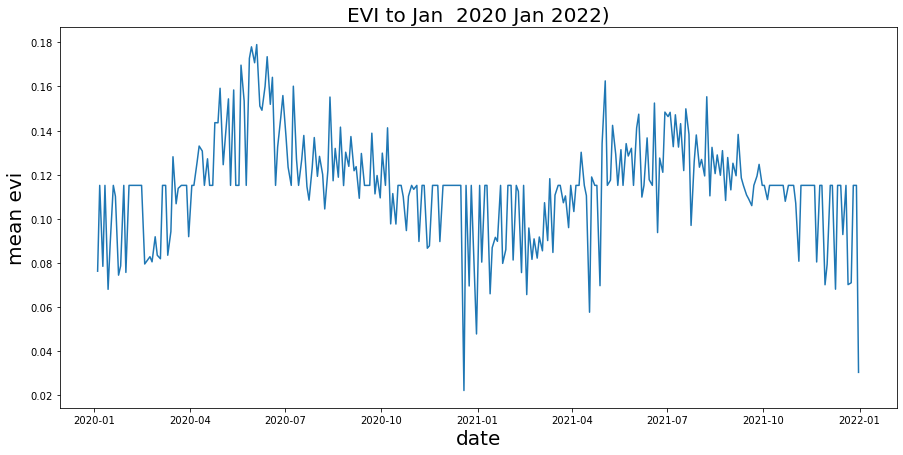

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(data=combined,y=combined['EVI'],x=combined['date'], ax=ax)


# we'll set the labels and title
ax.set_ylabel('mean evi',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('EVI to Jan  2020 Jan 2022)',fontsize=20);

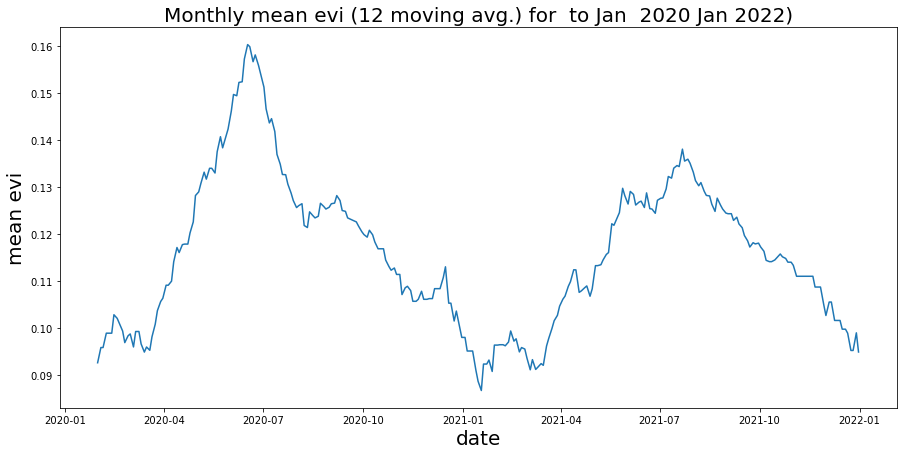

In [33]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=combined,y=combined['EVI'].rolling(window).mean(),x=combined['date'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean evi',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean evi ({window} moving avg.) for  to Jan  2020 Jan 2022)',fontsize=20);

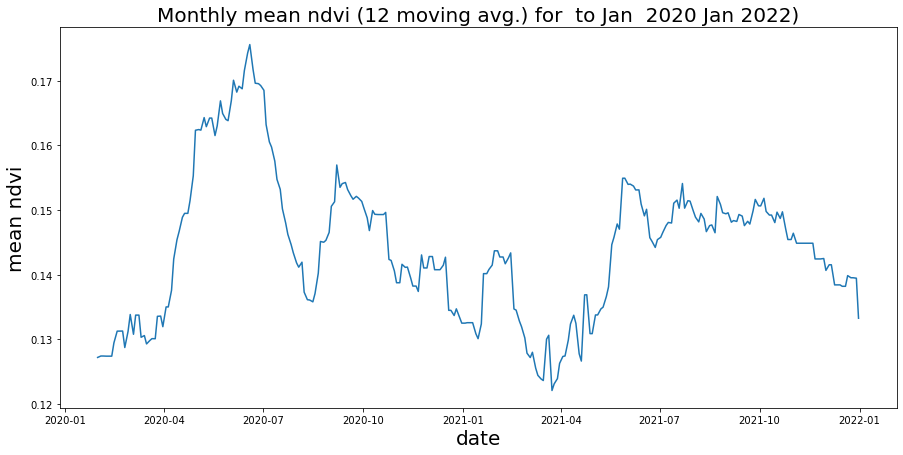

In [34]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=combined,y=combined['NDVI'].rolling(window).mean(),x=combined['date'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean ndvi',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean ndvi ({window} moving avg.) for  to Jan  2020 Jan 2022)',fontsize=20);

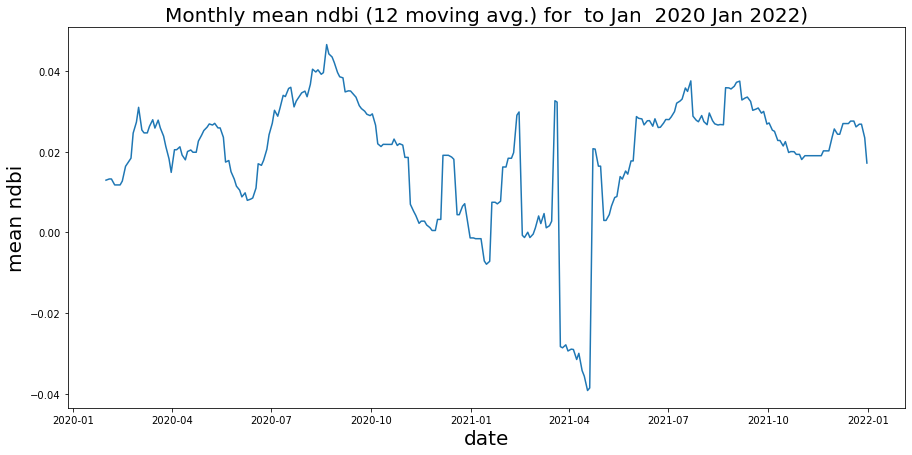

In [35]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=combined,y=combined['NDBI'].rolling(window).mean(),x=combined['date'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean ndbi',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean ndbi ({window} moving avg.) for  to Jan  2020 Jan 2022)',fontsize=20);

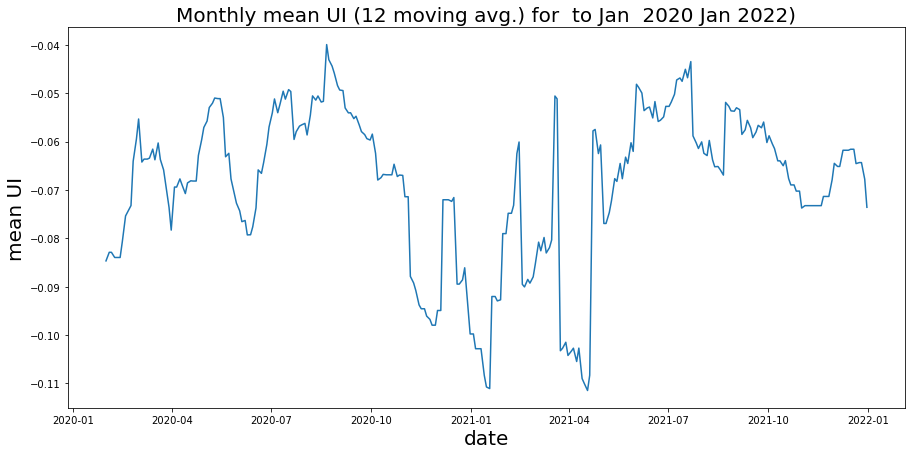

In [36]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=combined,y=combined['UI'].rolling(window).mean(),x=combined['date'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean UI',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean UI ({window} moving avg.) for  to Jan  2020 Jan 2022)',fontsize=20);

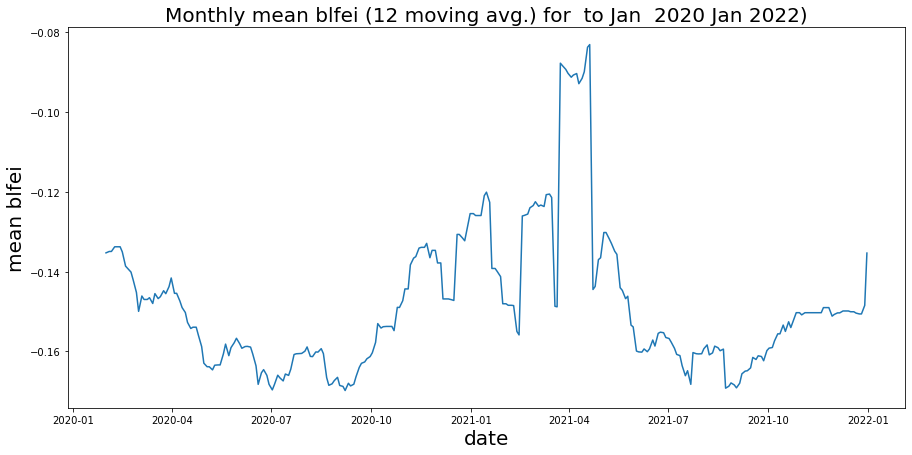

In [37]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=combined,y=combined['BLFEI'].rolling(window).mean(),x=combined['date'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean blfei',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean blfei ({window} moving avg.) for  to Jan  2020 Jan 2022)',fontsize=20);

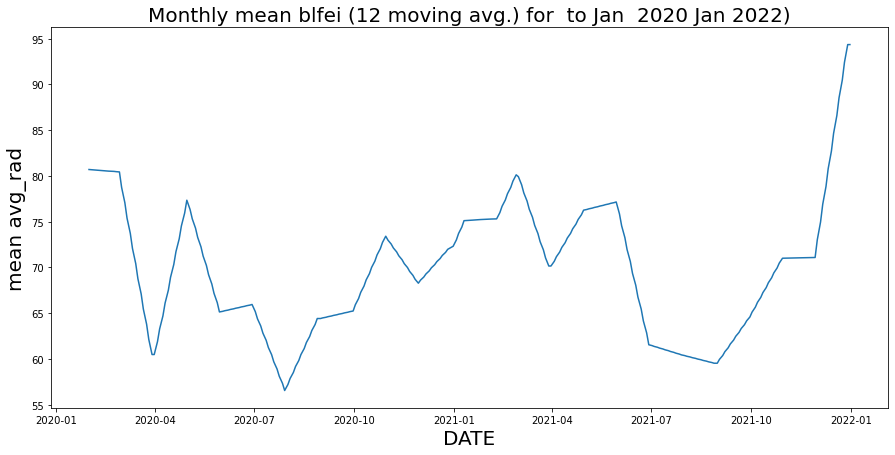

In [38]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=combined,y=combined['avg_rad'].rolling(window).mean(),x=combined['date'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean avg_rad',fontsize=20)
ax.set_xlabel('DATE',fontsize=20)
ax.set_title(f'Monthly mean blfei ({window} moving avg.) for  to Jan  2020 Jan 2022)',fontsize=20);

In [39]:
rgbScaled = {'min':0, 'max':0.3, 'bands':['B4','B3','B2']}
rgbUnscaled = {'min':0, 'max':3000, 'bands':['B4','B3','B2']}
ndvi = {'min':-1, 'max':1, 'bands':['NDVI']}
smead=Ss2.first()
# initialize our map
map5 = geemap.Map()
map5.centerObject(aoi, 7)
map5.addLayer(smead.clip(aoi), rgbUnscaled, "S2")
map5.addLayer(smead.clip(aoi), rgbScaled, "S2-scaled")
map5.addLayer(smead.clip(aoi), ndvi, "S2-NDVI")

map5.addLayerControl()
map5

Map(center=[39.51314304598321, 22.211757970370197], controls=(WidgetControl(options=['position', 'transparent_…

In [103]:
# Make the training dataset.
training = Ss2.first().sample(
    **{
        #'region': region,
        'scale': 10,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)

map5.addLayer(training, {}, 'training', False)
map5

AttributeError: 'ImageCollection' object has no attribute 'sample'

In [41]:
# Instantiate the clusterer and train it.
n_clusters =4
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

In [42]:
# Cluster the input using the trained clusterer.
resultcl= Ss2.first().cluster(clusterer)

# # Display the clusters with random colors.
map5.addLayer(resultcl.randomVisualizer(), {}, 'clusters')
map5

Map(bottom=25368.0, center=[38.90813299596705, 23.26904296875], controls=(WidgetControl(options=['position', '…

In [43]:
legend_keys = ['One', 'Two', 'Three', 'Four']
legend_colors = ['#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072']

# Reclassify the map
resultcl = resultcl.remap([0, 1, 2, 3], [1, 2, 3, 4])

map5.addLayer(
    resultcl, {'min': 1, 'max': 4, 'palette': legend_colors}, 'Labelled clusters'
)
map5.add_legend(
    legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright'
)
map5

Map(bottom=25368.0, center=[38.90813299596705, 23.26904296875], controls=(WidgetControl(options=['position', '…

In [104]:
### EKTOS APO TO OIKONOMAKI TA ALLA EINAI ABANDONED

kount_fil = ee.Geometry.Polygon([
          [
            22.952406182885166,
            39.35917348693331
          ],
          [
            22.952624447643757,
            39.359061499184136
          ],
          [
            22.952531576156613,
            39.35895702896919
          ],
          [
            22.952297888696194,
            39.35905890687299
          ],
          [
            22.952407523989677,
            39.359176597701556
          ]
        ])
kount_mavro = ee.Geometry.Polygon([
          [
            22.951523065567017,
            39.35919215154071
          ],
          [
            22.951737642288208,
            39.35908016382146
          ],
          [
            22.951886504888535,
            39.3592429607245
          ],
          [
            22.95165583491325,
            39.35935598510286
          ],
          [
            22.951521389186382,
            39.35919085538758
          ]
        ])

fil_28okt = ee.Geometry.Polygon( [
          [
            22.95275218784809,
            39.35951204139807
          ],
          [
            22.952881939709187,
            39.35942908792906
          ],
          [
            22.95277565717697,
            39.35932072981181
          ],
          [
            22.95261740684509,
            39.35940160957075
          ],
          [
            22.952740788459778,
            39.359515670610094
          ]
        ])

fill_28okt2 = ee.Geometry.Polygon([
          [
            22.95280247926712,
            39.359597846288914
          ],
          [
            22.95294027775526,
            39.35953174283249
          ],
          [
            22.9528571292758,
            39.359441271726006
          ],
          [
            22.95270960777998,
            39.35952889130942
          ],
          [
            22.952714301645756,
            39.35956570187087
          ],
          [
            22.952717654407024,
            39.35957736718557
          ],
          [
            22.952751852571964,
            39.35956777570473
          ],
          [
            22.952791415154934,
            39.35959499476857
          ],
          [
            22.95280247926712,
            39.359595253997696
          ],
          [
            22.952802814543247,
            39.35960017935096
          ],
          [
            22.95280449092388,
            39.359598883205386
          ]
        ])

# not abandoned
fil_fer = ee.Geometry.Polygon([
          [
            22.95489829033613,
            39.361775077721575
          ],
          [
            22.954826205968857,
            39.361703014235744
          ],
          [
            22.954844646155834,
            39.36168823861977
          ],
          [
            22.95478966087103,
            39.361634320555964
          ],
          [
            22.95481715351343,
            39.361614360492915
          ],
          [
            22.954944893717766,
            39.36154437061647
          ],
          [
            22.955089397728443,
            39.3616892755052
          ],
          [
            22.954903990030285,
            39.361783632015296
          ],
          [
            22.954898625612255,
            39.36177715148985
          ]
        ])

fil_fer_apenanti = ee.Geometry.Polygon([
          [
            22.955063581466675,
            39.362018745072554
          ],
          [
            22.955232560634613,
            39.361943052752395
          ],
          [
            22.95509308576584,
            39.36182692190997
          ],
          [
            22.95496568083763,
            39.36189742994447
          ],
          [
            22.955056875944138,
            39.36201148690843
          ]
        ])
#not abandoned
konst_gamv = ee.Geometry.Polygon( [
          [
            22.95320212841034,
            39.36192127823414
          ],
          [
            22.953552156686783,
            39.36170871710425
          ],
          [
            22.95335903763771,
            39.36154488906026
          ],
          [
            22.95302912592888,
            39.361739823651455
          ],
          [
            22.953198105096817,
            39.36191816758813
          ]
        ])

poi_oikonomaki= ee.Geometry.Polygon([[[
              22.949098348617554,39.35979978548018],
            [22.951193153858185,39.35979978548018 ],
            [22.951193153858185,39.36196275350115],
            [22.949098348617554,39.36196275350115],
            [22.949098348617554,39.35979978548018]]])

In [207]:
f1 = ee.Feature(konst_gamv,{'ID':'1_0','Class':'Not Abandoned','ClassPallete':'006633'})
f2 = ee.Feature(fil_fer_apenanti,{'ID':'2_0','Class':'Not Abandoned','ClassPallete':'006633'})
f3 = ee.Feature(fil_fer,{'ID':'3_0','Class':'Not Abandoned','ClassPallete':'006633'})
f4 = ee.Feature(fill_28okt2,{'ID':'4_0','Class':'Abandoned','ClassPallete':'E5FFCC'})
f5 = ee.Feature(fil_28okt,{'ID':'5_0','Class':'Abandoned','ClassPallete':'E5FFCC'})
f6 = ee.Feature(kount_mavro,{'ID':'6_0','Class':'Abandoned','ClassPallete':'E5FFCC'})
f7 = ee.Feature(poi_oikonomaki,{'ID':'7_0','Class':'Not Abandoned','ClassPallete':'006633'})
f8 = ee.Feature(kount_fil,{'ID':'8_0','Class':'Abandoned','ClassPallete':'E5FFCC'})

#f2 = ee.Feature(ee.Geometry.Point([22.947140336036682,39.36547976654773]).buffer(50),{'ID':'B'})
abandoned = ee.FeatureCollection([f4,f5,f6,f8])
not_abandoned =  ee.FeatureCollection([f1,f2,f3,f7])

In [238]:
test=ee.Geometry.Polygon( [
          [
            22.953597754240036,
            39.36231321852401
          ],
          [
            22.953289300203323,
            39.3619710485516
          ],
          [
            22.953646034002304,
            39.361769893300604
          ],
          [
            22.95384719967842,
            39.36204466708113
          ],
          [
            22.953813672065735,
            39.36210065858685
          ],
          [
            22.953859269618988,
            39.36215872380463
          ],
          [
            22.95384719967842,
            39.362174276979765
          ],
          [
            22.953593730926514,
            39.36232462416088
          ]
        ])

In [239]:
#for testing
#abandoned = [fill_28okt2,poi_oikonomaki,poi_rozou,fil_28okt,kount_mavro,kount_fil]

#for i in range(len(abandoned)):
tests = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry =test,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

tstests = geemap.ee_to_pandas(tests)

tstests[tstests == -9999] = np.nan
tstests['date'] = pd.to_datetime(tstests['date'],infer_datetime_format = True)

In [305]:
test_lot=ee.Geometry.Polygon([
          [
            22.953597754240036,
            39.36231321852401
          ],
          [
            22.953289300203323,
            39.3619710485516
          ],
          [
            22.953646034002304,
            39.361769893300604
          ],
          [
            22.95384719967842,
            39.36204466708113
          ],
          [
            22.953813672065735,
            39.36210065858685
          ],
          [
            22.953859269618988,
            39.36215872380463
          ],
          [
            22.95384719967842,
            39.362174276979765
          ],
          [
            22.953593730926514,
            39.36232462416088
          ]
        ])

In [306]:
#for testing
#abandoned = [fill_28okt2,poi_oikonomaki,poi_rozou,fil_28okt,kount_mavro,kount_fil]

#for i in range(len(abandoned)):
test_lot_ts = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry =test_lot,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

test_lot_tt = geemap.ee_to_pandas(test_lot_ts)

test_lot_tt[test_lot_tt == -9999] = np.nan
test_lot_tt['date'] = pd.to_datetime(test_lot_tt['date'],infer_datetime_format = True)

In [348]:
#abandoned - has no vegetation
test_rozou_gazi = ee.Geometry.Polygon( [
          [
            22.94616736471653,
            39.36514124100805
          ],
          [
            22.946286723017693,
            39.365071254665764
          ],
          [
            22.946207597851753,
            39.36497638417867
          ],
          [
            22.9460721462965,
            39.36505622055344
          ],
          [
            22.94616937637329,
            39.36514486992758
          ]
        ])

In [363]:
test_non_abandoned_area=ee.Geometry.Polygon([
          [
            22.94488728046417,
            39.36564980632223
          ],
          [
            22.944358885288235,
            39.365038075930826
          ],
          [
            22.944932878017422,
            39.3647394666072
          ],
          [
            22.945490777492523,
            39.36531802101217
          ],
          [
            22.944868505001068,
            39.36567054285175
          ]
        ])
test_non_area = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry =test_non_abandoned_area,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

nab_area = geemap.ee_to_pandas(test_non_area)

nab_area[nab_area == -9999] = np.nan
nab_area['date'] = pd.to_datetime(nab_area['date'],infer_datetime_format = True)

In [364]:
nab_df= pd.DataFrame({'EVI':nab_area['EVI'].mean(),'NDVI':nab_area['NDVI'].mean(),
                      'NDBI':nab_area['NDBI'].mean(),'BLFEI':nab_area['BLFEI'].mean(),
                      'UI':nab_area['UI'].mean(),'label':0},index=[0])

x_test=nab_df.drop('label',axis=1)
pred=clf.predict(hh)
acc = accuracy_score(nab_df['label'], pred)
acc

0.0

In [365]:
pred

array([1], dtype=int64)

TypeError: object of type 'NoneType' has no len()

In [355]:
#for testing
#abandoned = [fill_28okt2,poi_oikonomaki,poi_rozou,fil_28okt,kount_mavro,kount_fil]

#for i in range(len(abandoned)):
test_rozou = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry =test_rozou_gazi,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

rozou = geemap.ee_to_pandas(test_rozou)

rozou[rozou == -9999] = np.nan
rozou['date'] = pd.to_datetime(rozou['date'],infer_datetime_format = True)

In [356]:
rozou

reducer       date       EVI      NDVI      NDBI        UI     BLFEI
0      mean 2020-01-04  0.097464  0.207168  0.028363 -0.062537 -0.194145
1      mean 2020-01-06       NaN       NaN       NaN       NaN       NaN
2      mean 2020-01-09  0.093121  0.190330  0.006363 -0.083935 -0.186237
3      mean 2020-01-11       NaN       NaN       NaN       NaN       NaN
4      mean 2020-01-14  0.106155  0.200702 -0.051203 -0.179168 -0.141226
..      ...        ...       ...       ...       ...       ...       ...
284    mean 2021-12-21  0.063256  0.124847  0.056633 -0.055665 -0.159459
285    mean 2021-12-24  0.034426  0.060869  0.095472 -0.034569 -0.140136
286    mean 2021-12-26       NaN       NaN       NaN       NaN       NaN
287    mean 2021-12-29       NaN       NaN       NaN       NaN       NaN
288    mean 2021-12-31 -0.005228 -0.049161 -0.032029 -0.104932  0.130521

[289 rows x 7 columns]

In [240]:
tstests['EVI'] = tstests['EVI'].fillna(tstests['EVI'].mean())
tstests['NDVI'] = tstests['NDVI'].fillna(tstests['NDVI'].mean())
tstests['NDBI'] = tstests['NDBI'].fillna(tstests['NDBI'].mean())
tstests['BLFEI'] = tstests['BLFEI'].fillna(tstests['BLFEI'].mean())
tstests['UI'] = tstests['UI'].fillna(tstests['UI'].mean())

In [219]:
from sklearn.datasets import load_iris
from sklearn import tree

tsPandasabad['Label'] = 1 #abandoned
tsPandasnotabad['Label'] = 0 #not_abandoned

In [222]:
tsconcat=tsPandasabad.append(tsPandasnotabad,ignore_index=True)
tsconcat

reducer       date       EVI      NDVI      NDBI        UI     BLFEI  \
0      mean 2020-01-04  0.101744  0.185426 -0.012908 -0.133444 -0.187805   
1      mean 2020-01-06       NaN  0.191838       NaN       NaN       NaN   
2      mean 2020-01-09  0.104868  0.185469 -0.006893 -0.088207 -0.178962   
3      mean 2020-01-11  0.078035  0.108696 -0.051993 -0.155335 -0.100171   
4      mean 2020-01-14  0.089157  0.158957 -0.011833 -0.135057 -0.168585   
..      ...        ...       ...       ...       ...       ...       ...   
573    mean 2021-12-21  0.063996  0.104472 -0.001270 -0.118928 -0.114524   
574    mean 2021-12-24  0.047482  0.090393  0.045353 -0.049362 -0.130218   
575    mean 2021-12-26       NaN  0.105960       NaN       NaN       NaN   
576    mean 2021-12-29       NaN  0.105960       NaN       NaN       NaN   
577    mean 2021-12-31  0.035423  0.063182  0.021007 -0.090995 -0.090821   

     Label  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
573      0  
574      0  
575      0  
576      0  
577      0  

[578 rows x 8 columns]

In [234]:
tsconcat['EVI'] = tsconcat['EVI'].fillna(tsconcat['EVI'].mean())
tsconcat['NDVI'] = tsconcat['NDVI'].fillna(tsconcat['NDVI'].mean())
tsconcat['NDBI'] = tsconcat['NDBI'].fillna(tsconcat['NDBI'].mean())
tsconcat['BLFEI'] = tsconcat['BLFEI'].fillna(tsconcat['BLFEI'].mean())
tsconcat['UI'] = tsconcat['UI'].fillna(tsconcat['UI'].mean())

In [275]:
tsconcat['EVI'].mean()

0.11652791818278924

In [282]:
new_df_abad= pd.DataFrame({'EVI':tsPandasabad['EVI'].mean(),'NDVI':tsPandasabad['NDVI'].mean(),
                      'NDBI':tsPandasabad['NDBI'].mean(),'BLFEI':tsPandasabad['BLFEI'].mean(),
                      'UI':tsPandasabad['UI'].mean(),'label':1},index=[0])
new_df_notabad= pd.DataFrame({'EVI':tsPandasnotabad['EVI'].mean(),'NDVI':tsPandasnotabad['NDVI'].mean(),
                      'NDBI':tsPandasnotabad['NDBI'].mean(),'BLFEI':tsPandasnotabad['BLFEI'].mean(),
                      'UI':tsPandasnotabad['UI'].mean(),'label':0},index=[0])

In [283]:
new_df_concat=new_df_abad.append(new_df_notabad,ignore_index=True)
new_df_concat

EVI      NDVI      NDBI     BLFEI        UI  label
0  0.146133  0.191838  0.010939 -0.185010 -0.076604      1
1  0.087693  0.105960  0.025623 -0.129166 -0.066278      0

In [285]:
X=new_df_concat[['EVI','NDVI','NDBI','UI','BLFEI']]
y=new_df_concat['label']

In [286]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

[Text(390.6, 326.15999999999997, 'X[0] <= 0.117\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(195.3, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(585.9000000000001, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

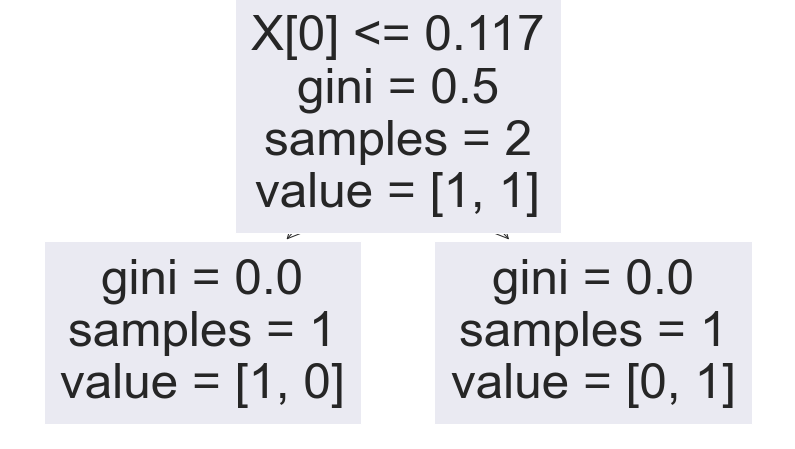

In [287]:
tree.plot_tree(clf)

In [341]:
test_df= pd.DataFrame({'EVI':tstests['EVI'].mean(),'NDVI':tstests['NDVI'].mean(),
                      'NDBI':tstests['NDBI'].mean(),'BLFEI':tstests['BLFEI'].mean(),
                      'UI':tstests['UI'].mean(),'label':0},index=[0])
xx=test_df.drop(test_df['label'])

In [359]:
#pred=clf.predict(xx)
#pred=clf.predict(zz)
pred=clf.predict(hh)

In [294]:
testl=np.arange(0,len(pred),1)
for i in range(len(pred)):
    testl[i] = 1

In [344]:
zz

EVI      NDVI      NDBI     BLFEI        UI
0  0.099272  0.123681  0.011915 -0.131511 -0.086992

In [360]:
pred

array([1], dtype=int64)

In [362]:
from sklearn.metrics import accuracy_score, recall_score

acc = accuracy_score(rozou_df['label'], pred)
acc

1.0

In [315]:
test_lott_df

EVI      NDVI      NDBI     BLFEI        UI  label
0  0.099272  0.123681  0.011915 -0.131511 -0.086992      1

In [319]:
test_lott_df= pd.DataFrame({'EVI':test_lot_tt['EVI'].mean(),'NDVI':test_lot_tt['NDVI'].mean(),
                      'NDBI':test_lot_tt['NDBI'].mean(),'BLFEI':test_lot_tt['BLFEI'].mean(),
                      'UI':test_lot_tt['UI'].mean(),'label':1},index=[0])


In [357]:
rozou_df= pd.DataFrame({'EVI':rozou['EVI'].mean(),'NDVI':rozou['NDVI'].mean(),
                      'NDBI':rozou['NDBI'].mean(),'BLFEI':rozou['BLFEI'].mean(),
                      'UI':rozou['UI'].mean(),'label':1},index=[0])

In [336]:
zz=test_lott_df.drop('label',axis=1)
zz

EVI      NDVI      NDBI     BLFEI        UI
0  0.099272  0.123681  0.011915 -0.131511 -0.086992

In [358]:
hh=rozou_df.drop('label',axis=1)
hh

EVI      NDVI     NDBI    BLFEI        UI
0  0.154028  0.206291  0.01534 -0.18397 -0.074123

In [108]:
#abandoned = [fill_28okt2,poi_oikonomaki,poi_rozou,fil_28okt,kount_mavro,kount_fil]

#for i in range(len(abandoned)):
tsabad = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry =abandoned,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

tsPandasabad = geemap.ee_to_pandas(tsabad)

tsPandasabad[tsPandasabad == -9999] = np.nan
tsPandasabad['date'] = pd.to_datetime(tsPandasabad['date'],infer_datetime_format = True)

In [110]:
#abandoned = [fill_28okt2,poi_oikonomaki,poi_rozou,fil_28okt,kount_mavro,kount_fil]

#for i in range(len(abandoned)):
tsanotbad = Ss2.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                              geometry =not_abandoned,
                              bands = ['EVI','NDVI','NDBI','UI','BLFEI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)

tsPandasnotabad = geemap.ee_to_pandas(tsanotbad)

tsPandasnotabad[tsPandasnotabad == -9999] = np.nan
tsPandasnotabad['date'] = pd.to_datetime(tsPandasnotabad['date'],infer_datetime_format = True)

In [109]:
tsPandasabad

reducer       date       EVI      NDVI      NDBI        UI     BLFEI
0      mean 2020-01-04  0.101744  0.185426 -0.012908 -0.133444 -0.187805
1      mean 2020-01-06       NaN       NaN       NaN       NaN       NaN
2      mean 2020-01-09  0.104868  0.185469 -0.006893 -0.088207 -0.178962
3      mean 2020-01-11  0.078035  0.108696 -0.051993 -0.155335 -0.100171
4      mean 2020-01-14  0.089157  0.158957 -0.011833 -0.135057 -0.168585
..      ...        ...       ...       ...       ...       ...       ...
284    mean 2021-12-21  0.047644  0.133261 -0.045215 -0.192247 -0.109931
285    mean 2021-12-24  0.088211  0.172500  0.006656 -0.068130 -0.171066
286    mean 2021-12-26       NaN       NaN       NaN       NaN       NaN
287    mean 2021-12-29       NaN       NaN       NaN       NaN       NaN
288    mean 2021-12-31  0.106729  0.185201 -0.004422 -0.120379 -0.176494

[289 rows x 7 columns]

In [111]:
tsPandasnotabad

reducer       date       EVI      NDVI      NDBI        UI     BLFEI
0      mean 2020-01-04  0.055337  0.100655  0.029139 -0.070211 -0.129987
1      mean 2020-01-06       NaN       NaN       NaN       NaN       NaN
2      mean 2020-01-09  0.055110  0.099501  0.052206 -0.032609 -0.138156
3      mean 2020-01-11  0.031180  0.042398  0.029108 -0.090076 -0.091559
4      mean 2020-01-14  0.044670  0.077264  0.023981 -0.088316 -0.111064
..      ...        ...       ...       ...       ...       ...       ...
284    mean 2021-12-21  0.063996  0.104472 -0.001270 -0.118928 -0.114524
285    mean 2021-12-24  0.047482  0.090393  0.045353 -0.049362 -0.130218
286    mean 2021-12-26       NaN       NaN       NaN       NaN       NaN
287    mean 2021-12-29       NaN       NaN       NaN       NaN       NaN
288    mean 2021-12-31  0.035423  0.063182  0.021007 -0.090995 -0.090821

[289 rows x 7 columns]

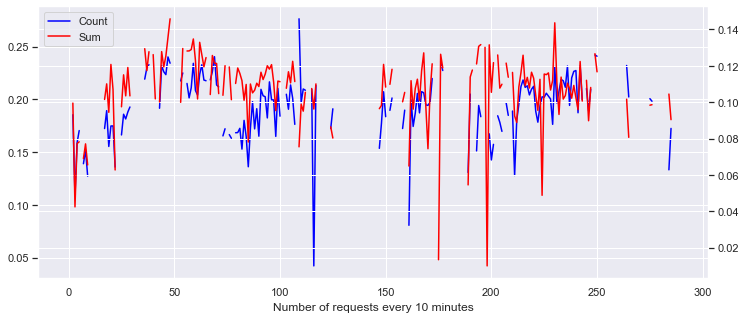

In [112]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = tsPandasabad['NDVI'].plot(color='blue', grid=True, label='abandoned')
ax2 = tsPandasnotabad['NDVI'].plot(color='red', grid=True, secondary_y=True, label='not_abandoned')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

# APO DW KAI KATW THA TO KANOUME WSTE TO DATAFRAME NA ALLAZEII ANALOGA ME TO TI THELEI NA DEI O XRHSTHS

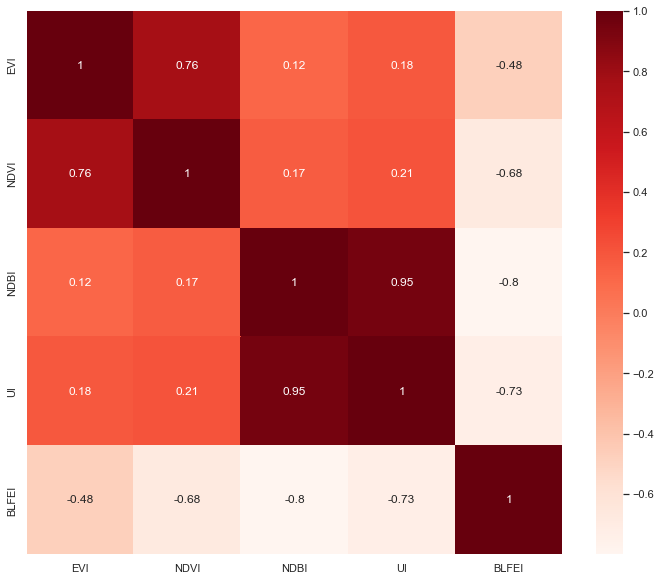

In [113]:
import seaborn as sns

import statsmodels.api as sm
from scipy import stats
import plotly.offline as py
import plotly.graph_objs as go

#Let's the variable correlation using the seaborn libary

plt.figure(figsize=(12,10))
cor = tsPandasabad.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

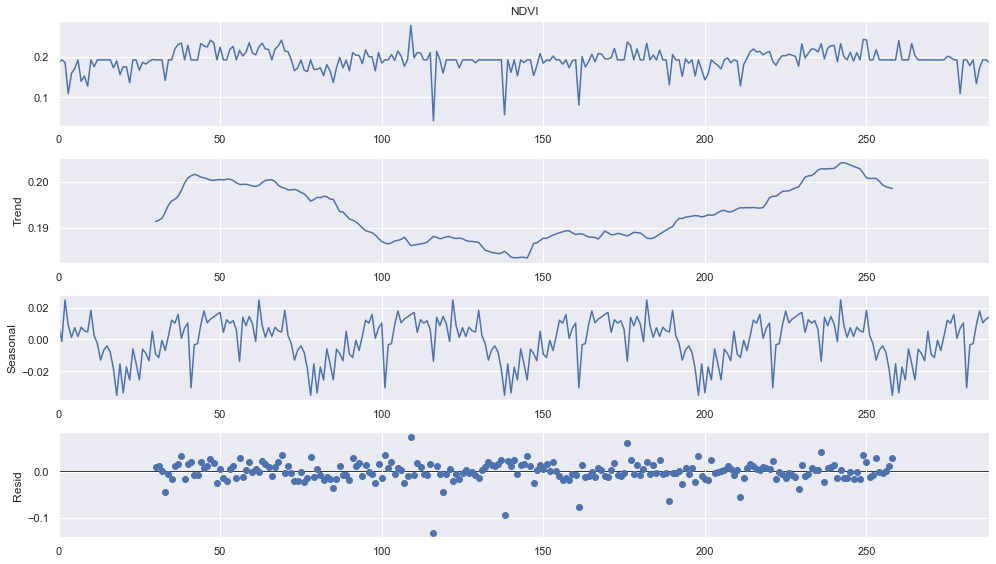

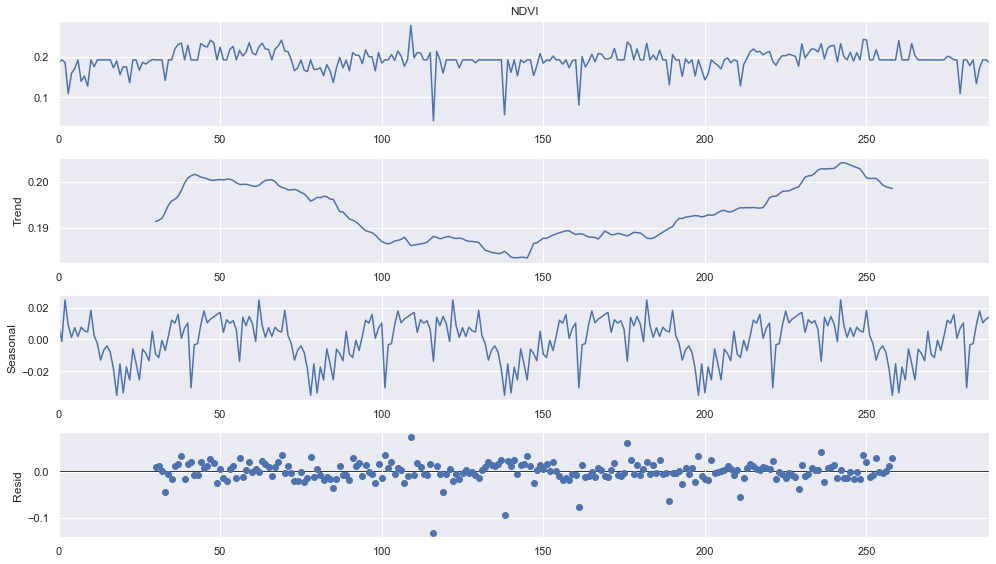

In [122]:
# Seasonality for BitcoinPrices
s = sm.tsa.seasonal_decompose(tsPandasabad['NDVI'].fillna(tsPandasabad['NDVI'].mean()), period=60)
s.plot()


In [123]:
#working_Data = stocks

s = sm.tsa.seasonal_decompose(tsPandasabad['NDVI'], period=60)

trend = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
seasonal = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

residual= go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

observed = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

w_data = [trend, seasonal, residual, observed]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=w_data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

In [137]:
tsPandasnotabad['NDVI'].fillna(tsPandasnotabad['NDVI'].mean(),inplace=True)

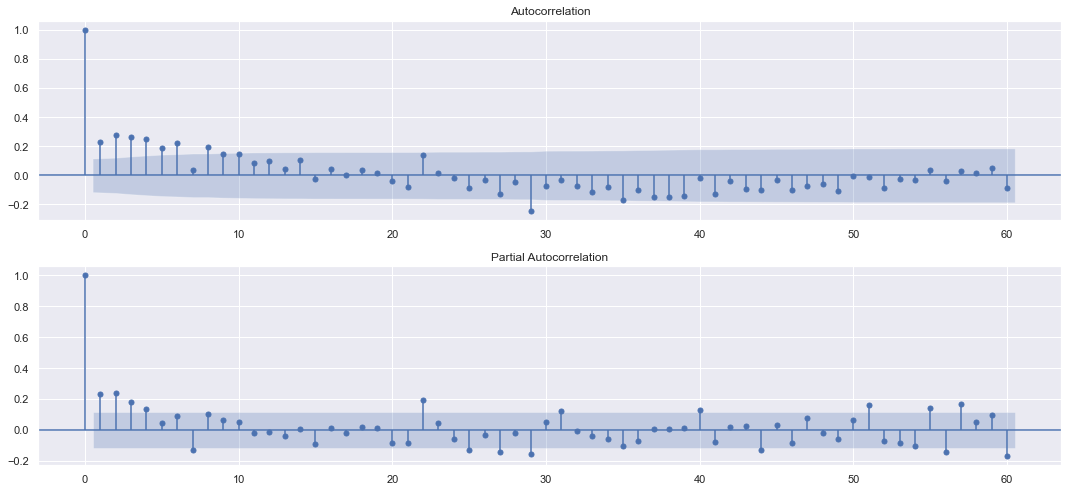

In [135]:
# Autocorrelation for ndvi
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tsPandasabad['NDVI'].squeeze(), lags=60, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tsPandasabad['NDVI'].squeeze(), lags=60, ax=ax)
plt.tight_layout()
plt.show()

In [142]:
abandoned_ndvi = go.Scatter(
    x = tsPandasabad['date'],
    y = tsPandasabad['NDVI'],
    mode = 'lines',
    name = 'abandoned',
    line = dict(color=('rgb(244, 146, 65)'), width=2) 
)
not_abandoned_ndvi = go.Scatter(
    x =  tsPandasabad['date'],
    y = tsPandasnotabad['NDVI'],
    mode = 'lines',
    name = 'not_abandoned',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

d = [abandoned_ndvi, not_abandoned_ndvi]
layout = dict(title = 'Comparison of abandoned buiding ndvi vs not abandoned building',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'ndvi'))
fig = dict(data=d, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

# AYTO DES TO
https://github.com/Toroitich6783/classification-using-GEE

https://github.com/afrozalopa/Project_Report_Group-1

https://geohackweek.github.io/GoogleEarthEngine/05-classify-imagery/

https://geemap.org/workshops/GeoPython_2021/#zonal-statistics

In [88]:
labels=['abandoned','not-abandoned']

abandoned_vis = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC'],
}


#METHODOLOGY FOR PSEUDO-CLASSIFIER

get values(e.g ndvi etc) for different hand picked points of interest that we already know if they are abandoned or not
compute the mean of each value in every category, for example compute all ndvi means for abandoned pois
this mean will be the threshold for a place being abandoned or not
then add a random polygon and see if this place is classified correctly

#this probably works better using a ml classifier but can't work my head around it rn

In [ ]:
def (df):
    if(df['EVI'].loc[i] > df['EVI'].mean() and df['NDVI'].loc[i]>df['NDVI'].mean() and df['avg_rad'].loc[i]<df['avg_rad'].mean()):
        df['label'].loc[i] = labels[0]
    else:
        df['label'].loc[i] = labels[1]

In [201]:
S_sentinel_bands = Ss2.select('[B1-B12]')
S_sentinel_bands

In [205]:
s2tes = ee.Image("COPERNICUS/S2/20160111T112432_20160111T113311_T28PDT").tasseledCap()


In [206]:

s2tes.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B10',
 'B11',
 'B12',
 'TCB',
 'TCG',
 'TCW']

In [210]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(s2tes.bandNames(), 
         colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

NameError: name 'ep' is not defined

In [208]:
Map4 = geemap.Map()
Map4.addLayer(s2tes, {"min": [-1000, -1000, -100], "max": [9000, 2000, 800], "bands": ["TCB", "TCG", "TCW"]}, "S2 TC")
Map4.centerObject(s2tes, 10)

Map4

Map(center=[11.263334863301033, -15.41364498211138], controls=(WidgetControl(options=['position', 'transparent…

# papers pou einai xrhsima
https://github.com/DominiquePaul/GDP-Satellite-Prediction

https://towardsdatascience.com/hyperspectral-image-analysis-getting-started-74758c12f2e9

https://github.com/worldbank/OpenNightLights/tree/master/onl/tutorials

https://github.com/konkyrkos/hyperspectral-image-classification

https://github.com/yohman/workshop-python-spatial-stats

https://github.com/holderbp/pwpd

https://www.frontiersin.org/articles/10.3389/fbuil.2018.00032/full
    
https://icaarconcrete.org/wp-content/uploads/2020/11/15ICAAR-SanchezL-2.pdf
    
https://www.sciencedirect.com/science/article/pii/S2666549220300013
    
https://www.researchgate.net/publication/268816675_Assessment_of_Concrete_Surfaces_Using_Multi-Spectral_Image_Analysis

There are a few basic boolean operations that Google Earth Engine includes as built-ins for Images. The output is a binary file that sets a pixel value to 1 if it meets the condition and 0 if it doesnt. Those operations include:

    lt: "less than"
    lte: "less than or equal to"
    eq: "equal to"
    gt: "greater than or equal to"
    gte: "greater than

The method compares the Image object the method is called on as the left-hand side of the comparison with the value passed as the input argument to the function on the right-hand side. This input can be a scalar value that will be compared to all pixels in the image, or another image that will be used as an element-wise / pixel-wise comparison.

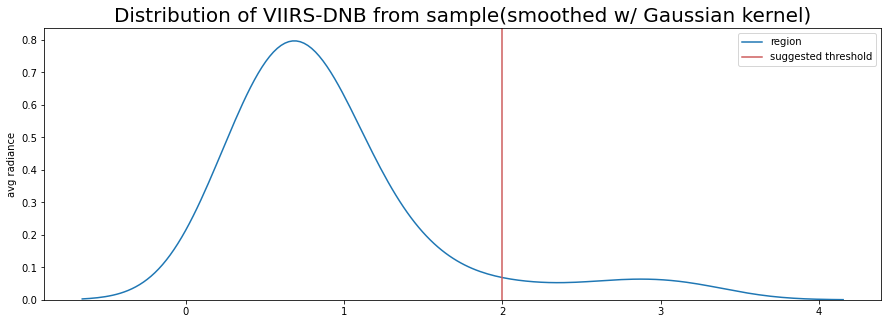

In [175]:
# create a 200 km buffer around the center of Catalonia
aoi_2 = ee.Geometry.Point( [
          22.949130535125732,
          39.364330950394994
        ]).buffer(200000);
viirs2019_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2021-12-01","2021-12-31").select('avg_rad').median()

# extract a number array from this region
arr = geemap.ee_to_numpy(viirs2019_12, region=aoi_2)

# create a histogram
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(arr.flatten(), label='region',legend=True, ax=ax)
ax.axvline(2, color='indianred', label='suggested threshold')
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS-DNB from sample(smoothed w/ Gaussian kernel)', fontsize=20);
plt.ylabel('avg radiance')
plt.legend();

Based on our histogram of radiance in the sample region, it might be interesting mask all values that are not greater than or equal to 4.



In [182]:
viirs2019_12_mask = viirs2019_12.gte(2)

# initialize our map
map3 = geemap.Map(center=[ 39.364330950394994,22.949130535125732],zoom=7)
map3.add_basemap('SATELLITE')

# we'll mask the image with itself to keep the visualization clean
map3.addLayer(viirs2019_12_mask.mask(viirs2019_12_mask), {}, "Avg rad >=2")
map3.addLayerControl()
map3

Map(center=[39.364330950394994, 22.949130535125732], controls=(WidgetControl(options=['position', 'transparent…

In [184]:
zones = viirs2019_12.gt(1.5).add(viirs2019_12.gt(2)).add(viirs2019_12.gt(4))

# initialize our map
map3 = geemap.Map(center=[ 39.364330950394994,22.949130535125732],zoom=7)
map3.add_basemap('SATELLITE')

map3.addLayer(zones.mask(zones), {'palette':['#cc0909','#e67525','#fff825']}, 'zones')

map3.addLayerControl()
map3

Map(center=[39.364330950394994, 22.949130535125732], controls=(WidgetControl(options=['position', 'transparent…

Now we can see variation in radiance in a way that sheds "light" (apologies for the pun!) on activity around denser urban areas.

Later in this tutorial, we'll look at calculating the difference in two Images -- and this is a another potential for leveraging conditional operators.M

## Ayta apo katw den exoun toso nohma pros to paron

In [157]:
import os
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'viirsfirst.tif')
imageti = viirs2.first().clip(poi_rozou).unmask()
geemap.ee_export_image(
    imageti, filename=filename, scale=90, region=poi_rozou, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Christos\Downloads\viirsfirst.tif


In [161]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Lei Dong
# Email: arch.dongl@gmail.com


import numpy as np
import rasterio
import sys
from osgeo import gdal, osr, ogr
from math import radians, cos, sin, asin, sqrt
from rasterio.features import shapes
from shapely.geometry import shape


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers.
    return c * r


# 按一定band的阈值选择坐标点
def filter(data, thre):
    rst = {}
    for row in range(len(data)):
        for col in range(len(data[row])):
            lon = xOrigin + (col + 0.5) * pixelWidth #pixal center
            lat = yOrigin + (row + 0.5) * pixelHeight
            if data[row][col] > thre:
                rst[(row, col)] = [lon, lat, data[row][col]]
    return rst


# 每个选择出来的点，计算和周围一定距离阈值内的点的球面距离
def neighbor(rst, grid):
    foo = {}
    for key in rst:
        originX = key[0] - grid
        originY = key[1] - grid
        extend_key = []
        for i in range(2 * grid + 1):
            extend_key.append((originX, originY))
            originX += 1
            originY += 1
        for j in extend_key:
            if j in rst:
                lon1, lat1, value1 = rst[key]
                lon2, lat2, value2 = rst[j]
                distance = haversine(lon1, lat1, lon2, lat2)
                if (key, j) not in foo and (j, key) not in foo:
                    foo[(key, j)] = [lon1, lat1, value1, lon2, lat2, value2, distance]
    return foo


# 点对之间的筛选条件
def cluster(foo, dist):
    final = {}
    for key in foo:
        if foo[key][6] <= dist:
            if key[0] not in final:
                final[key[0]] = 1
            if key[1] not in final:
                final[key[1]] = 1
    return final


def array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array):
    array = array[::-1] # reverse array so the tif looks like the array
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


# test
if __name__ == "__main__":
    # open geotiff
    try:
        dataset = gdal.Open("viirsfirst.tif")
    except Exception as e:
        print(e)
    
    # select tiff band
    try:
        band_num = 1
        band = dataset.GetRasterBand(band_num) 
    except Exception as e:
        print(e)
    
    # get coord information
    transform = dataset.GetGeoTransform()
    xOrigin = transform[0] # top left x
    yOrigin = transform[3] # top left y
    pixelWidth = transform[1] # width pixal resolution
    pixelHeight = transform[5] # hight pixal resolution (negative value)
    print(xOrigin, yOrigin, pixelWidth, pixelHeight)


    # Transform the band value to array
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    data = band.ReadAsArray(0, 0, cols, rows)
    
    # filter data
    rst = filter(data, thre = 10)
    foo = neighbor(rst, grid = 100)
    final = cluster(foo, dist = 50)
    print(len(rst), len(foo), len(final))
    
    # export
    rasterOrigin = (xOrigin, xOrigin)
    newRasterfn = 'test.tif'
    array = np.zeros((rows, cols))
    for row in range(len(data)):
        for col in range(len(data[row])):
            if (row, col) in final:
                array[row][col] = 1
    array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array)

    
# raster to vector (polygon)
mask = None
with rasterio.drivers():
    with rasterio.open('test.tif') as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(shapes(image, mask=mask, transform=src.affine)))

        
geoms = list(results)
print (geoms[0])
print (shape(geoms[0]['geometry']))

22.944315588119764 39.36573694927176 0.0008084837557075694 -0.0008084837557075694
12 20 12


TypeError: 'module' object is not callable

In [160]:
rasterio.open('test.tif')

<open DatasetReader name='test.tif' mode='r'>

In [ ]:
# get South Korea national boundary geometry
sovolos= ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME', 'Magnisias')).first()).geometry()

# revise our reducer function to be to get SOL for South Korea
def get_sovolos_sol(img):
    sol = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=sovolos, scale=500, maxPixels=2e9).get('avg_rad')
    return img.set('date', img.date().format()).set('SOL',sol)

In [ ]:
# reduce collection
sovolos_sol = viirs.map(get_sovolos_sol)

# get lists
nested_list = sovolos_sol.reduceColumns(ee.Reducer.toList(2), ['date','SOL']).values().get(0)

# convert to dataframe
soldf = pd.DataFrame(nested_list.getInfo(), columns=['date','SOL'])
#soldf['date'] = pd.to_datetime(soldf['date'])
#soldf = soldf.set_index('date')

In [ ]:
volosMap2 = geemap.Map()
volosMap2.centerObject(sovolos, zoom=7)
volosMap2.add_basemap("SATELLITE")
volosMap2.addLayer(sovolos, {}, "Greece")
volosMap2.addLayer(viirs.select('avg_rad').median(), {'min':0,'max':10}, "VIIRS 2014-2021 mean")
volosMap2.addLayerControl()
volosMap2

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=soldf, ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Monthly Sum Of Lights (SOL) for Volos (Jan 2014 to May 2021)',fontsize=20);

In [ ]:
magnisia_lights

In [ ]:
# Import the packages and classes needed in this example:
import numpy as np
from sklearn.linear_model import LinearRegression

#x = pd.Timestamp(soldf['date']).to_pydatetime()
# Create a numpy array of data:
x=magnisia_lights.index.values.reshape(-1,1)
#x=x.map(dt.datetime.toordinal)
y =magnisia_lights['mean']
# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x, y) 

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model.intercept_)

# Print the Slope:
print('slope:', model.coef_) 

# Predict a Response and print it:
y_pred = model.predict(x)
print('Predicted response:', y_pred, sep='\n')

In [ ]:
magnisia_lights.index.values

In [ ]:
#https://github.com/Digdgeo/Ndvi2Gif

In [ ]:
from ndvi2gif import NdviSeasonality

# You could need a first login to sart with python Earth Engine login
Map = geemap.Map()
Map.add_basemap('Google Satellite')
Map

# You can use any of these depending on your input
MyClass = NdviSeasonality(poi)
#MyClass = ndvi_seasonality(shp)
#MyClass = ndvi_seasonality(geojson)

wintermax = MyClass.get_year_composite().select('winter').max()
median = MyClass.get_year_composite().median()
Map.addLayer(wintermax, {'min': 0, 'max': 0.6}, 'winterMax')
Map.addLayer(median, {'min': 0.1, 'max': 0.8}, 'median') 

MyClass.get_gif()


%%html
<img src="mygif.gif">

In [ ]:
## reading GeoTiff file

import geopandas as gpd
from rasterio.transform import xy
import rioxarray as rxr
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.colors as colors
from adjustText import adjust_text


# load shapefile in geopandas dataframe
# source: https://maps.princeton.edu/catalog/stanford-cp683xh3648
Lebanon_regions = gpd.read_file('data/stanford-cp683xh3648-shapefile.zip')

#Lebanon_regions.plot()

years = ['2012','2015', '2020']
############### using VIIRS
# need to put /vsigzip/ in front of path with .gz
raster20 = rasterio.open('/vsigzip/data/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.median_masked.tif.gz')
raster12 = rasterio.open('/vsigzip/data/VNL_v2_npp_201204-201303_global_vcmcfg_c202102150000.median_masked.tif.gz')
raster15 = rasterio.open('/vsigzip/data/VNL_v2_npp_2015_global_vcmslcfg_c202102150000.median_masked.tif.gz')


#raster.meta

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


raster_dic = {years[0] :raster12, years[1]: raster15,years[2]:raster20}
Lebanon_regions[f'light{years[0]}'] = 0.0
Lebanon_regions[f'light{years[2]}'] = 0.0
for y in years:
    raster = raster_dic[f'{y}']
    for i in range(1,len(Lebanon_regions)+1):
        coords = getFeatures(Lebanon_regions.iloc[i-1:i,:])
        out_img, out_transform = mask(raster, shapes=coords, crop=True)
        light = np.average(out_img)
        Lebanon_regions.loc[i-1,f'light{y}'] = light

# get difference
for y in years[0:2]:
    Lebanon_regions[f'light_diff_{y}_20'] = Lebanon_regions.light2020 - Lebanon_regions.loc[:,f'light{y}']
    Lebanon_regions[f'light_reldiff_{y}_20'] = Lebanon_regions.loc[:,f'light_diff_{y}_20'] / Lebanon_regions.loc[:,f'light{y}']


# 
minx, miny, maxx, maxy = Lebanon_regions.geometry.total_bounds

# plot in levels
columns = [f'light{y}' for y in years]
vmin = Lebanon_regions[columns].min().min()
vmax = Lebanon_regions[columns].max().max()

for y in years:
    fig, ax = plt.subplots()
    Lebanon_regions.plot(column = f'light{y}', legend=True, cmap='PRGn', ax = ax, vmin=vmin, vmax=vmax, alpha=.7)
    texts = []
    for i in range(len(Lebanon_regions)):
        point = Lebanon_regions.geometry[i].centroid
        lab = np.round(Lebanon_regions.loc[i,f'light{y}'],1)
        txt = ax.annotate(lab, xy=(point.x, point.y), xytext=(-3, 8), textcoords="offset points", size = 8, fontweight = 'bold', arrowprops={'arrowstyle':'-'})
        texts.append(txt)
    adjust_text(texts)
    ax.set_title(f'average light in {y}')
    ax.text(x= maxx, y = miny, s='unit: nW/cm2/sr', fontsize=8, ha='right')
    ax.axis('off')    
    fig.savefig(f'out/Lebanon_nightlight_{y}.png')


# plot relative difference
columns = [f'light_reldiff_{y}_20' for y in years[0:2]]
vmin = Lebanon_regions[columns].min().min()
vmax = Lebanon_regions[columns].max().max()

for y in years[0:2]:
    fig, ax = plt.subplots()
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    Lebanon_regions.plot(column = f'light_reldiff_{y}_20', legend=True, cmap='PiYG', norm=divnorm, vmin=vmin, vmax=vmax, ax= ax, alpha=.8)
    texts = []
    for i in range(len(Lebanon_regions)):
        point = Lebanon_regions.geometry[i].centroid
        lab = np.round(Lebanon_regions.loc[i,f'light_reldiff_{y}_20'],1)
        txt = ax.annotate(lab, xy=(point.x, point.y), xytext=(-3, 8), textcoords="offset points", size = 8, fontweight = 'bold', arrowprops={'arrowstyle':'-'})
        texts.append(txt)
    adjust_text(texts)
    ax.set_title(f'relative change in average light from {y}-2020')
    ax.axis('off')
    fig.savefig(f'out/Lebanon_nightlight_diff{y}.png')